# El Salvador Tree Cover EDA with Rasterio

**Useful links**
- https://rasterio.readthedocs.io/en/latest/quickstart.html
- https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html
- https://www.hatarilabs.com/ih-en/how-to-clip-sentinel-2-bands-to-a-area-of-interest-with-python-rasterio-and-fiona-tutorial

Masking and resampling with Rasterio. In the future, the ESA data tiles will match perfectly to TOF, so won't need resample.
- https://gis.stackexchange.com/questions/329434/creating-an-in-memory-rasterio-dataset-from-numpy-array/329439
- https://gis.stackexchange.com/questions/337627/python-mask-raster-array-using-shapefile-or-rasterio

### Data Description
**TOF**  
Sentinel 1 and 2 based percent tree cover product that maps extent at 10m scale (10m resolution)  

**Hansen Tree Cover 2010**  
Landsat based (30m resolution) percent tree cover product that includes forest cover for the year 2010. Individual tifs downloaded [here](https://glad.umd.edu/dataset/global-2010-tree-cover-30-m). All individual tifs covering Africa and LAC downloaded.  

**Hansen Tree Cover 2000 - not used**  
hansen_treecover.tif (30m resolution)

**Hansen Loss 2000-2020**  
Year of gross forest cover loss event. Forest loss during the period 2000–2019, defined as a stand-replacement disturbance, or a change from a forest to non-forest state. Encoded as either 0 (no loss) or else a value in the range 1–19, representing loss detected primarily in the year 2001–2019, respectively. Not all tifs covering Africa and LAC downloaded.  
[Download 2000-2019](https://earthenginepartners.appspot.com/science-2013-global-forest/download_v1.7.html)  
[Download 2000-2020](https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/download.html)

**ESA Land Cover Classes**  
[ESA LC tif](http://maps.elie.ucl.ac.be/CCI/viewer/download.php): 2015 global land cover map at 300 m spatial resolution.  

**Subnational Jurisdictions - Shapefile**  
.geojson or shapefile containing each country's subnational administrative boundaries.


**Considerations**  
Issue: Hansen tree cover loss is from 2000-2019 while our data is from 2020. We can't be sure that the areas where we are subtracting loss (i.e loss in 2001) still have loss in 2020.  
Solution:  

Issue: There will be some areas, especially in dense forests, where TOF will say 100% and Hansen will say 80% which will screw up the mean. Some areas where we see larger differences in mean percent tree cover but total hectares is exactly the same is because Hansen caps canopy cover in a certain area.  
Solution: Create three subsets for tree cover, including hectares above 10%, 40% and 70%. 10-40% is considered a scattered or system and 40-70% is open to closed and 70% + is closed canopy. We can do comparisons at these different thresholds.  

Issue: ESA land cover classes are not completely reliable - shrubland for ex. Multiple land cover products will be released in November alongside TOF. What's our messaging?  
Solution: Clearly communicate that land cover maps have errors in them too.

## Folder Organization
------------

    ├── analysis-notebook.ipynb
    ├── ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7.tif         <- ESA global landcover classes
    ├── hansen_treecover2010                                   <- Hansen global tree cover tifs 2010
    │   ├── Hansen_GFC-2019-v1.7_lossyear_10N_090W.tif            with individual 10x10 degree granules
    │   └── etc.
    │
    ├── hansen_lossyear2019                                    <- Hansen global forest loss tifs 2000-2019
    │   ├── Hansen_GFC-2019-v1.7_lossyear_10N_090W.tif            with individual 10x10 degree granules
    │   └── etc.
    │                
    ├── hansen_lossyear2020                                    <- Hansen global forest loss tifs 2000-2020
    │   ├── Hansen_GFC-2019-v1.7_lossyear_10N_090W.tif            with individual 10x10 degree granules
    │   └── etc.
    │
    ├── Country                                                <- Country folder 
    │   │  
    │   ├── raw_data                                           <- Raw data folder for the country             
    │   │   ├── admin boundaries shapefile/geojson             <- administrative boundaries shapefile
    │   │   ├── country_tof.tif                                <- Original TOF tree cover for the country 
    │   │   ├── country_hansen_treecover2010.tif               <- Combined Hansen tree cover for the country
    │   │   ├── country_hansen_loss2020.tif                    <- Combined Hansen loss for the country
    │   │   ├── country_hansen_treecover2010_wloss.tif         <- Hansen tree cover - loss for the country
    │   │   ├── clipped_rasters                                <- TOF, Hansen, ESA rasters clipped by admin
    │   │   │   ├── admin1.tif 
    │   │   │   └── etc.
    │   │   └── resampled_rasters                              <- Hansen and ESA resampled rasters by admin
    │   │       ├── admin1.tif 
    │   │       └── etc.
    │   │    
    │   ├── prepared_data                                      <- Clean data for the analysis pipeline           │   │   │
    │   │   ├── country_tof_padded.tif                         <- updated TOF tif with padded boundaries
    │   │   ├── xx
    │   │   ├── some folder with all the merged polygons?      <- xx
    │   │   │   ├── xx
    │   │   │   └── etc.
    │   │   └── xx                                             <- xx
    │   │       ├── xx 
    │   │       └── etc.
    │   │  
    │   └── analyses                                           <- csv files containing stats/tables  
    │       ├── hansen_v_tof.csv                               <- tof versus hansen tree cover 
    │       ├── ipcc_above.csv                                 <- % tree cover above thresholds for IPCC
    │       ├── ipcc_between.csv                               <- % tree cover between thresholds for IPCC
    │       └── esa_something.csv                              <- some sort of ESA class analysis
    └── xx

# Data Preparation

In [105]:
import os
import rasterio as rs
from rasterio.mask import mask
from rasterio.merge import merge
from rasterio.plot import show, show_hist, adjust_band
from rasterio.enums import Resampling
from rasterio import Affine, MemoryFile

import numpy as np 
import numpy.ma as ma 
import seaborn as sns
import matplotlib.pyplot as plt
import pyproj
import geopandas as gpd 
import shapely
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
import pandas as pd
import fiona
from contextlib import contextmanager  
from skimage.transform import resize
import math
import urllib.request
from osgeo import gdal

%matplotlib inline

In [2]:
rs.__version__

'1.1.5'

In [106]:
gpd.__version__

'0.6.1'

## Create Hansen Tree Cover and Loss Tifs

In [79]:
# will need to be adapted to take in a country with North and South lat/lon coordinates

def create_hansen_tif(country, shapefile, lon, lat):
    '''
    Identifies the latitude and longitude increments for a country 
    to import appropriate Hansen tree cover and tree cover loss tif files. 
    Returns combined tifs as one file in the country's folder.
    
    Attributes
    ----------
    country : str
        a string indicating the country files to import
    shapefile : .geojson or .shp file
        shapefile containing subnational administrative boundaries level 0-2
    lon : str
        geographic coordinate that specifies the east–west position of the country
    lat : str
        geographic coordinate that specifies the north-south position of the country
    
    '''
    # reproject shapefile
    #shapefile = shapefile.to_crs("EPSG:4326")
    
    # Reproject the geometries by replacing the values with projected ones
    # FLAG -- what difference does this make compared to above
    shapefile.geometry = shapefile.geometry.to_crs("EPSG:4326")
    
    # identify min/max bounds for the country
    bounds = shapefile.geometry.bounds
    min_x = bounds.minx.min() 
    min_y = bounds.miny.min()
    max_x = bounds.maxx.max()
    max_y = bounds.maxy.max()
    #print(min_x, min_y, max_x, max_y)

    # identify the lowest and highest 10 lat/lon increments for the country
    lower_x = math.floor(min_x / 10) * 10 # index on top left corner
    lower_y = math.ceil(min_y / 10) * 10 
    upper_x = math.ceil(max_x / 10) * 10 
    upper_y = math.ceil(max_y / 10) * 10
    # print(f'Increments for {country}: ({lower_x}, {lower_y}, {upper_x}, {upper_y})')

    # create a list of tif file names for the country
    tree_cover_files = []
    loss_files = []
    
    for x_grid in range(lower_x, upper_x, 10):
        for y_grid in range(lower_y, upper_y + 10, 10):
            
            cover_tif = (f'hansen_treecover2010/treecover2010_' \
                         f'{str(y_grid).zfill(2)}{lon}_{str(np.absolute(x_grid)).zfill(3)}{lat}.tif')
            
            loss_tif = (f'hansen_lossyear2020/Hansen_GFC-2020-v1.8_lossyear_' \
                        f'{str(y_grid).zfill(2)}{lon}_{str(np.absolute(x_grid)).zfill(3)}{lat}.tif')
            
            if not os.path.exists(cover_tif) or not os.path.exists(loss_tif):
                print(f'{cover_tif} or {loss_tif} does not exist.')
            
            tree_cover_files.append(cover_tif)
            loss_files.append(loss_tif)
    
    # remove duplicate file names
    tree_tifs = [x for x in tree_cover_files if os.path.exists(x)] 
    loss_tifs = [x for x in loss_files if os.path.exists(x)]
    
    # convert tree cover and loss tifs into a virtual raster tile    
    gdal.BuildVRT(f'{country}/{country}_hansen_treecover2010.vrt', tree_tifs)
    gdal.BuildVRT(f'{country}/{country}_hansen_loss2020.vrt', loss_tifs)

    # open vrts and convert to a single .tif
    translateoptions = gdal.TranslateOptions(gdal.ParseCommandLine("-ot Byte -co COMPRESS=LZW"))

    source = gdal.Open(f'{country}/{country}_hansen_treecover2010.vrt')
    ds = gdal.Translate(f'{country}/{country}_hansen_treecover2010.tif', source, options=translateoptions)
    os.remove(f'{country}/{country}_hansen_treecover2010.vrt')
                      
    source = gdal.Open(f'{country}/{country}_hansen_loss2020.vrt')
    ds = gdal.Translate(f'{country}/{country}_hansen_loss2020.tif', source, options=translateoptions)
    os.remove(f'{country}/{country}_hansen_loss2020.vrt')
    
    return None

In [80]:
create_hansen_tif('El Salvador', gpd.read_file('El Salvador/El Salvador_admin.geojson'), 'N', 'W')

In [81]:
create_hansen_tif('Costa Rica', gpd.read_file('Costa Rica/costa-rica-wgs84.geojson'), 'N', 'W')

/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## Update Hansen Tree Cover Tif

In [83]:
def remove_loss(country):
    '''
    Takes in a country name to import hansen tree cover loss tifs. Updates tree cover 
    to 0 if loss was detected between 2011-2020. Returns updated tif in the country's folder.
    
    Attributes
    ----------
    country : str
        a string indicating the country files to import
      '''
    
    # read in the tree cover and loss files
    hansen_tif = rs.open(f'{country}/{country}_hansen_treecover2010.tif')
    hansen_cover = rs.open(f'{country}/{country}_hansen_treecover2010.tif').read(1)
    hansen_loss = rs.open(f'{country}/{country}_hansen_loss2020.tif').read(1)
    
    # If there was loss between 2011-2020 (values between 11-20, make then 0 in tree cover
    hansen_cover_new = np.where((hansen_loss >= 11) & (hansen_loss <= 20), 0, hansen_cover)
    
    # check bin counts after loss removed
    print(f'{np.sum(hansen_cover > 0)} pixels to start. {np.sum(hansen_cover_new > 0)} tree cover pixels after loss removed')
    
    # save updated raster
    out_meta = hansen_tif.meta
    out_meta.update({'driver': 'GTiff',    
                     'dtype': 'uint8',
                     'height': hansen_cover_new.shape[0],
                     'width': hansen_cover_new.shape[1],
                     'count': 1})
    outpath = f'{country}/{country}_hansen_treecover2010_wloss.tif'
    with rs.open(outpath, 'w', **out_meta) as dest:
            dest.write(hansen_cover_new, 1) # FLAG -- why 1 is needed here?
        
    return None

In [84]:
remove_loss('El Salvador')

736879675 pixels to start. 677478922 tree cover pixels after loss removed


In [85]:
remove_loss('Costa Rica')

464617281 pixels to start. 426566839 tree cover pixels after loss removed


## Pad TOF Extent

In [114]:
def pad_tof_raster(country, shapefile):
    
    '''
    Increase the raster extent to match the boundas of a country's shapefile
    and fill with no data value.
    
    Attributes
    ----------
    country : str
        a string indicating the country files to import
    shapefile : .geojson or .shp file
        shapefile containing subnational administrative boundaries level 0-2
    '''
    
    # reproject shapefile
    shapefile = shapefile.to_crs("EPSG:4326")

    # identify min/max bounds for the country
    bounds = shapefile.geometry.bounds
    min_x = bounds.minx.min() 
    min_y = bounds.miny.min()
    max_x = bounds.maxx.max()
    max_y = bounds.maxy.max()
    print(f'Original bounds: ({min_x}, {min_y}, {max_x}, {max_y})')
    
    # round to the nearest .1 lat/lon
    lower_x = math.floor(min_x * 1) / 1 # also need to account for the negatives?
    lower_y = math.floor(min_y * 1) / 1 
    upper_x = (math.floor(max_x * 1) / 1) if max_x < 0 else (math.ceil(max_x * 1) / 1)
    upper_y = math.ceil(max_y * 1) / 1
    print(f'Padding bounds: ({lower_x}, {lower_y}, {upper_x}, {upper_y})')
          
    # create tif with new output bounds, filled with no data value
    warp_options = gdal.WarpOptions(format='Gtiff', 
                                    dstSRS='EPSG:4326',
                                    dstNodata=255,
                                    outputBounds=[lower_x, lower_y, upper_x, upper_y])
          
    ds = gdal.Warp(f'{country}/{country}_tof_padded.tif', # destination file
                   f'{country}/{country}_tof.tif',        # original file
                   options=warp_options)                  # define specifics
    
    return None


In [108]:
pad_tof_raster('El Salvador', gpd.read_file('El Salvador/El Salvador_admin.geojson'))

/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Original bounds: (-90.03624725299994, 13.417916298000023, -88.95311737099996, 13.99701213800006)
Padding bounds: (-91.0, 13.0, -89.0, 14.0)


In [93]:
pad_tof_raster('Costa Rica', gpd.read_file('Costa Rica/costa-rica-wgs84.geojson'))

/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Original bounds: (-87.10184904046184, 5.49857041364919, -82.55231898795682, 11.219757912256666)
Padding bounds: (-89.0, 6.0, -84.0, 13.0)


In [109]:
# rasterio geom window - fits the bounds of the geometry plus optional padding
# https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html#rasterio.features.geometry_window
cr_tof = rs.open('Costa Rica/Costa Rica_tof.tif').read(1)
rs.features.geometry_window(cr_tof, 
                            gpd.read_file('Costa Rica/costa-rica-wgs84.geojson'),
                            pad_x=.5, 
                            pad_y=.5)

In [62]:
max_x = -82.55231898795682
upper_x = (math.floor(max_x * 10) / 10) if max_x < 0 else (math.ceil(max_x * 10) / 10)
upper_x

-82.56

In [87]:
max_x = -82.55231898795682
upper_x = math.ceil(max_x * 1) / 1
upper_x -1

-83.0

In [57]:
max_x = 82.55231898795682
upper_x = (math.floor(max_x * 10) / 10) if max_x < 0 else (math.ceil(max_x * 10) / 10)
upper_x

82.6

In [95]:
shapefile = gpd.read_file('Costa Rica/costa-rica-wgs84.geojson')

In [96]:
shapefile.geometry.bounds

minx       miny       maxx       maxy
0  -85.225659  10.109038 -84.827092  10.389386
1  -84.341693   9.622506 -84.132088   9.861633
2  -84.253801   9.254671 -83.840040   9.572033
3  -84.367680   9.914267 -84.160955  10.413694
4  -84.145894   9.847564 -84.084156   9.931675
..        ...        ...        ...        ...
76 -84.592696   9.569590 -84.403502   9.925489
77 -85.449169  10.670787 -84.880578  11.065570
78 -84.362149  10.048149 -84.226587  10.276312
79 -84.034999   9.964382 -83.858583  10.190042
80 -84.518360  10.167054 -84.315016  10.270422

[81 rows x 4 columns]

In [97]:
# identify min/max bounds for the country
bounds = shapefile.geometry.bounds
min_x = bounds.minx.min() 
min_y = bounds.miny.min()
max_x = bounds.maxx.max()
max_y = bounds.maxy.max()
print(min_x, min_y, max_x, max_y)

-87.10184904046184 5.49857041364919 -82.55231898795682 11.219757912256666


In [39]:
# round to the nearest .1 lat/lon
lower_x = math.floor(min_x * 10) / 10
lower_y = math.floor(min_y * 10) / 10 
upper_x = math.ceil(max_x * 10) / 10 
upper_y = math.ceil(max_y * 10) / 10
print(f'Padding lat/lon with: ({lower_x}, {lower_y}, {upper_x}, {upper_y})')

Padding lat/lon with: (-87.2, 5.4, -82.5, 11.3)


In [112]:

# Testing the resample function in a new location
# this would immediately resample the hansen and esa tifs to a higher resolution
# before they are clipped into individual admin boundary rasters for the country
# challenge is that ESA is at the global scale until the clipping stage whereas hansen
# is already clipped to the general country scale

# def resample_raster(country, data, resolution):
    
#     '''
#     Takes in a country name to import a clipped raster and resamples the raster
#     to convert it to higher resolution. Returns the new rasters as individuals files
#     in the country's "resampled_rasters" folder.

#     Resampling a raster involves multiplying the pixel size by the scale factor 
#     and dividing the dimensions by the scale factor. A scale >1 is an upsample
#     and a scale <1: downsample.

#         i.e. given a pixel size of 250m, dimensions of (1024, 1024) and a scale of 2,
#         the resampled raster would have an output pixel size of 500m and dimensions of (512, 512)
        
#     Attributes
#     ----------
#     country : str
#         a string indicating the country files to import
#     data : str
#         the dataset to import and resample
#     resolution : int
#         resolution of the dataset to calculate scale for upsampling or downsampling the pixel size
#         (hansen is 30m, esa is 300m)
#     '''
    
#     if not os.path.exists(f'{country}/resampled_rasters/hansen'):
#         os.makedirs(f'{country}/resampled_rasters/hansen')
    
#     if not os.path.exists(f'{country}/resampled_rasters/esa'):
#         os.makedirs(f'{country}/resampled_rasters/esa')
        
#     # calculate scale based on resolution input
#     scale = resolution / 10 if scale != 10 else print('Resampling not required.')
    
#     # import new shapefile containing only polygons
#     shapefile = gpd.read_file(f'{country}/{country}_adminboundaries.geojson')
    
#     inpath = f'{country}/{country}_hansen_treecover2010_wloss.tif'
#     outpath = f'{country}/resampled_rasters/{data}/{admin}.tif'
#     raster = rs.open(inpath)
#     height = int(raster.height)
#     width = int(raster.width)

    
#     admin_boundaries = list(shapefile.ADM2_ES)
    
#     for admin in admin_boundaries:
        
#         inpath = f'{country}/clipped_rasters/{data}/{admin}.tif'
#         outpath = f'{country}/resampled_rasters/{data}/{admin}.tif'
#         raster = rs.open(inpath)
#         height = int(raster.height)
#         width = int(raster.width)
        
#         # resample data to target shape -- use Resampling.nearest not Resampling.bilinear
#         resampled = raster.read(out_shape=(raster.count, (height * scale), (width * scale)),
#                                 resampling=Resampling.nearest)
        
#         # removes extra index
#         resampled = resampled.squeeze()
        
#         # scale image transform
#         transform = raster.transform * raster.transform.scale((width / resampled.shape[-1]),
#                                                               (height / resampled.shape[-2]))
        
#         new_dataset = rs.open(outpath, 'w', 
#                               driver='GTiff',
#                               height=resampled.shape[0], 
#                               width=resampled.shape[1], 
#                               count=1,
#                               dtype="uint8",
#                               crs='+proj=longlat +datum=WGS84 +no_defs',
#                               transform=transform)
        
#         new_dataset.write(resampled, 1)
#         new_dataset.close()
        
#     # Reopen as DatasetReader
#     dataset = rs.open(outpath)
#     return None

## Clip and Resample Rasters

In [20]:
def create_clippings(country, shapefile):
    
    '''
    Takes in a country name to import tof/hansen rasters and masks out administrative 
    boundaries based on the shapefile. Saves new shapefile with only polygons.
    Returns masked rasters as individual files in the country's "clipped_rasters" folder. 
    
    Attributes
    ----------
    country : str
        a string indicating the country files to import
    shapefile : .geojson or .shp file
        shapefile containing subnational administrative boundaries level 0-2
       '''
    
    if not os.path.exists(f'{country}/clipped_rasters/hansen'):
        os.makedirs(f'{country}/clipped_rasters/hansen')
    
    if not os.path.exists(f'{country}/clipped_rasters/tof'):
        os.makedirs(f'{country}/clipped_rasters/tof')
    
    if not os.path.exists(f'{country}/clipped_rasters/esa'):
        os.makedirs(f'{country}/clipped_rasters/esa')
    
   
    tof_raster = rs.open(f'{country}/{country}_tof_padded.tif') 
    hansen_raster = rs.open(f'{country}/{country}_hansen_treecover2010_wloss.tif')
    esa_raster = rs.open('ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7.tif')
    
    
    # reproject the shapefile if not espg 4326
    shapefile = shapefile.to_crs("EPSG:4326")
    
    # preprocess shapefile from multipolygon to single
    counter = 0
    for idx, row in shapefile.iterrows():
        if type(row.geometry) == MultiPolygon:
            counter +=1

    if counter > 0:
        shapefile = shapefile.explode()

    # add integer to admin name if duplicated
    shapefile.ADM2_ES = np.where(shapefile.ADM2_ES.duplicated(keep=False), 
                                 shapefile.ADM2_ES + shapefile.groupby('ADM2_ES').cumcount().add(1).astype(str),
                                 shapefile.ADM2_ES)
    
    # reset index
    shapefile = shapefile.reset_index()
    shapefile.drop(columns=['level_0', 'level_1'], inplace=True)
    
    # for some reason cannot save updated shapefile anymore
    # CPLE_NotSupportedError: GeoJSON driver doesn't support creating a layer on a read-only datasource
    #shapefile.to_file(f'{country}/{country}_adminboundaries.geojson', driver='GeoJSON')
    
    def mask_raster(polygon, admin, raster, folder):
        out_img, out_transform = mask(dataset=raster, shapes=[polygon], crop=True, nodata=0)
        out_meta = raster.meta
        out_meta.update({'driver': 'GTiff',    
                         'dtype': 'uint8',
                         'height': out_img.shape[1],
                         'width': out_img.shape[2],
                         'transform': out_transform})
        outpath = f'{country}/clipped_rasters/{folder}/{admin}.tif'
        with rs.open(outpath, 'w', **out_meta) as dest:
            dest.write(out_img)
        return None
    
    for polygon, admin in zip(shapefile.geometry, shapefile.ADM2_ES):
        mask_raster(polygon, admin, tof_raster, 'tof')
        mask_raster(polygon, admin, hansen_raster, 'hansen')
        mask_raster(polygon, admin, esa_raster, 'esa')
           
    return f"{country}'s rasters clipped and saved."

In [7]:
create_clippings('El Salvador', gpd.read_file('El Salvador/El Salvador_admin.geojson'))

/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


"El Salvador's rasters clipped and saved."

In [30]:
create_clippings('Costa Rica', gpd.read_file('Costa Rica/cri_admbnda_adm2_2020.shp'))

/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


"Costa Rica's rasters clipped and saved."

In [110]:
# same issue: https://gis.stackexchange.com/questions/382533/inconsistently-getting-input-shapes-do-not-overlap-raster-crs-appear-to-match
cr_shape1 = gpd.read_file('Costa Rica/cri_admbnda_adm2_2020.shp') # download from humdata
cr_shape2 = gpd.read_file('Costa Rica/costa-rica-wgs84.geojson') # from John
cr_shape3 = gpd.read_file('Costa Rica/Costa Rica_adminboundaries.geojson') # saved after explode

tof_raster = rs.open(f'Costa Rica/Costa Rica_tof.tif') 
hansen_raster = rs.open(f'Costa Rica/Costa Rica_hansen_treecover2010_wloss.tif')
esa_raster = rs.open('ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7.tif')

In [111]:
# check the crs of every shapefile and raster
tof_raster.crs, hansen_raster.crs, esa_raster.crs, cr_shape2.crs, cr_shape3.crs, cr_shape1.crs

(CRS.from_epsg(4326),
 CRS.from_epsg(4326),
 CRS.from_epsg(4326),
 {'init': 'epsg:4326'},
 {'init': 'epsg:4326'},
 {'proj': 'tmerc',
  'lat_0': 0,
  'lon_0': -84,
  'k': 0.9999,
  'x_0': 500000,
  'y_0': 0,
  'ellps': 'WGS84',
  'units': 'm',
  'no_defs': True})

In [9]:
def resample_raster(country, data, scale):
    
    '''
    Takes in a country name to import a clipped raster and resamples the raster
    to convert it to higher resolution. Returns the new rasters as individuals files
    in the country's "resampled_rasters" folder.

    Resampling a raster involves multiplying the pixel size by the scale factor 
    and dividing the dimensions by the scale factor. A scale >1 is an upsample
    and a scale <1: downsample.

        i.e. given a pixel size of 250m, dimensions of (1024, 1024) and a scale of 2,
        the resampled raster would have an output pixel size of 500m and dimensions of (512, 512)
        
    Attributes
    ----------
    country : str
        a string indicating the country files to import
    data : str
        the dataset to import and resample
    scale : int
        factor applied to upsample or downsample the pixel size
    '''
    
    if not os.path.exists(f'{country}/resampled_rasters/hansen'):
        os.makedirs(f'{country}/resampled_rasters/hansen')
    
    if not os.path.exists(f'{country}/resampled_rasters/tof'):
        os.makedirs(f'{country}/resampled_rasters/tof')
    
    if not os.path.exists(f'{country}/resampled_rasters/esa'):
        os.makedirs(f'{country}/resampled_rasters/esa')
        
    # check resolution to determine what scale needs to be resampled.
    
    
    # import new shapefile containing only polygons
    shapefile = gpd.read_file(f'{country}/{country}_adminboundaries.geojson')
    admin_boundaries = list(shapefile.ADM2_ES)
    
    for admin in admin_boundaries:
        
        inpath = f'{country}/clipped_rasters/{data}/{admin}.tif'
        outpath = f'{country}/resampled_rasters/{data}/{admin}.tif'
        raster = rs.open(inpath)
        height = int(raster.height)
        width = int(raster.width)
        
        # resample data to target shape -- use Resampling.nearest not Resampling.bilinear
        resampled = raster.read(out_shape=(raster.count, (height * scale), (width * scale)),
                                resampling=Resampling.nearest)
        
        # removes extra index
        resampled = resampled.squeeze()
        
        # scale image transform
        transform = raster.transform * raster.transform.scale((width / resampled.shape[-1]),
                                                              (height / resampled.shape[-2]))
        
        new_dataset = rs.open(outpath, 'w', 
                              driver='GTiff',
                              height=resampled.shape[0], 
                              width=resampled.shape[1], 
                              count=1,
                              dtype="uint8",
                              crs='+proj=longlat +datum=WGS84 +no_defs',
                              transform=transform)
        
        new_dataset.write(resampled, 1)
        new_dataset.close()
        
    # Reopen as DatasetReader
    dataset = rs.open(outpath)
    return None

In [10]:
resample_raster('El Salvador', 'hansen', 3) # hansen upsampled 30 -> 10m scale
resample_raster('El Salvador', 'esa', 30) # esa upsampled 300 -> 10m scale
re sample_raster('El Salvador', 'tof', 1) 

## Merge Admin Polygons

In [31]:
def merge_polygons(country, data):
    '''
    Takes in a country to iterate through the resampled rasters and identify
    which admin boundaries are composed of multipolygons. Returns combined files
    as one for the admin, removes individual files.
    '''
    
    # identify separated admins
    extensions = ['1', '2', '3', '4', '5', '6']

    filenames = os.listdir(f'El Salvador/resampled_rasters/hansen')
    multi_admins = []
    
    # iterate through hansen folder (should match tof/esa)
    for file in filenames:
        if any(ext in file for ext in extensions):
            multi_admins.append(file)
            original_admin = file[:-5] + file[-4:]
            multi_admins.append(original_admin)

    multi_admins = list(set(multi_admins))
    print(multi_admins)
    
    # Iterate over raster files and add them to the list in 'read mode'
    src_files_to_mosaic = []
    for tif in multi_admins:
        if data == 'tof':
            src = rs.open(f'{country}/clipped_rasters/{data}/{tif}')
        else:
            src = rs.open(f'{country}/resampled_rasters/{data}/{tif}')
        src_files_to_mosaic.append(src)
        
    # Merge the rasters - returns a single mosaic array and the transformation info
    mosaic, out_transform = merge(src_files_to_mosaic)

    # Update the metadata and write to file
    outpath = f'{country}/resampled_rasters/{data}/{original_admin[:-4]}_comb.tif'
    out_meta = src.meta.copy()
    out_meta.update({'driver': "GTiff",
                     'dtype': 'uint8',
                     'height': mosaic.shape[1],
                     'width': mosaic.shape[2],
                     'transform': out_transform})
    
    with rs.open(outpath, "w", **out_meta) as dest:
        dest.write(mosaic)

    # confirm merged file exists then delete old tifs
    for filename in multi_admins:
        if os.path.exists(f'{country}/resampled_rasters/{data}/{original_admin[:-4]}_comb.tif'):
            try:
                os.remove(f'{country}/resampled_rasters/{data}/{filename}')
            except: pass 

    return None

In [23]:
merge_polygons('El Salvador', 'tof')
merge_polygons('El Salvador', 'hansen')
merge_polygons('El Salvador', 'esa')

['San Marcos.tif', 'San Marcos1.tif', 'San Marcos2.tif']
['San Marcos.tif', 'San Marcos1.tif', 'San Marcos2.tif']
['San Marcos.tif', 'San Marcos1.tif', 'San Marcos2.tif']


In [8]:
# function to group the admin boundaries together

# def merge_polygons(country, data):
#     '''
#     Takes in a country to iterative through the resampled rasters and identify
#     which admin boundaries are composed of multipolygons. Returns combined files
#     as one for the admin, removes individual files.
#     '''
    
#     # identify separated admins
#     extensions = ['1', '2', '3', '4', '5']

#     multi_admins = []
    
#     for filename in os.listdir(f'{country}/resampled_rasters/{data}'):
#         if any(ext in filename for ext in extensions):
#             multi_admins.append(filename)
#             original_admin = filename[:-5] + filename[-4:]
#             multi_admins.append(original_admin)

#     multi_admins = list(set(multi_admins))
    
#     # combine into a virtual raster tile    
#     gdal.BuildVRT(f'{country}/resampled_rasters/{data}/{original_admin[:-4]}_comb.vrt', multi_admins)

#     # convert to a single .tif
#     translateoptions = gdal.TranslateOptions(gdal.ParseCommandLine("-ot Byte -co COMPRESS=LZW"))
#     source = gdal.Open(f'{country}/resampled_rasters/{data}/{original_admin[:-4]}_comb.vrt')
#     ds = gdal.Translate(f'{country}/resampled_rasters/{data}/{original_admin[:-4]}_comb.tif', source, options=translateoptions)
    
#     # remove vrt and old individual tifs?
#     os.remove(f'{country}/resampled_rasters/{data}/{original_admin[:-4]}_comb.vrt')

#     for filename in multi_admins:
#         os.remove(f'{country}/resampled_rasters/{data}/{filename}')
    
#     for file in multi_admins:
#         print(f'{country}/resampled_rasters/{data}/{original_admin[:-4]}_comb.vrt')
    
#     gdal.BuildVRT(f'{country}/resampled_rasters/{data}/{original_admin[:-4]}_comb.vrt', 
#                   multi_admins, 
#                   options=gdal.BuildVRTOptions(srcNodata=255, VRTNodata=255))
   
#     ds = gdal.Open(f'{country}/resampled_rasters/{data}/{original_admin[:-4]}_comb.vrt')
    
#     translateoptions = gdal.TranslateOptions(gdal.ParseCommandLine("-ot Byte -co COMPRESS=LZW -a_nodata 255"))
    
#     ds = gdal.Translate(f'{country}/resampled_rasters/{data}/{original_admin[:-4]}_comb.vrt', ds, options=translateoptions)    
    

#     return None

# Calculate Statistics

1) The mean tree cover and number of hectares between % thresholds for tof and hansen admin one boundaries.

2) The number of hectares per IPCC class above a certain % threshold. So 10+%, 20+%,  50+%, etc. This is to deal with the Hansen data often times having a huge overestimation of canopy cover at 10% threshold. Most people use either 30% or 50% for the Hansen data.

3) The number of hectares per IPCC class between % thresholds. So 0 - 20%, 20 - 40%, etc. This would help us understand open vs. closed canopy forests.

## TOF vs Hansen

In [25]:
def reshape_for_stats(raster): 
    '''
    Takes in a raster file and returns a reshaped 10x10 grid array. 
    
    Attributes
    ----------
    raster : str
        tree cover raster file to be reshaped
    '''
    
    def round_down(num, divisor):
         return num - (num%divisor)

    # round down rows and cols to nearest 10th
    rows, cols = round_down(raster.shape[0], 10), round_down(raster.shape[1], 10)

    # clip according to rounded numbers and reshape
    rounded = raster[:rows, :cols]
    reshaped = np.reshape(rounded, (int(rounded.shape[0] / 10), 10, int(rounded.shape[1] / 10), 10))

    return reshaped


In [29]:
def calculate_stats_tof_hansen(country, shapefile):
    
    '''
    Takes in a country name to import tof/hansen rasters and calculates mean tree cover 
    thresholds per administrative boundary. Returns a pandas dataframe with statistics 
    saved as a csv file in the country's folder.
    
    Attributes
    ----------
    country : str
        a string indicating the country files to import
    shapefile : .geojson or .shp file
        shapefile containing subnational administrative boundaries level 0-2
    '''
    
    tree_cover = pd.DataFrame(columns=['admin', 
                                       'tof_mean_tc',
                                       'tof_0-20',
                                       'tof_20-40',
                                       'tof_40-60',
                                       'tof_60-80',
                                       'tof_80-100',
                                       'hansen_mean_tc',
                                       'hansen_0-20',
                                       'hansen_20-40',
                                       'hansen_40-60',
                                       'hansen_60-80',
                                       'hansen_80-100'])
    
    admin_boundaries = list(shapefile.ADM2_ES)
    
    for filename in os.listdir(f'{country}/resampled_rasters/{data}'):
    
    for admin in admin_boundaries:
        
        tof = rs.open(f'{country}/clipped_rasters/tof/{admin}.tif').read(1)
        hansen = rs.open(f'{country}/resampled_rasters/hansen/{admin}.tif').read(1)

        # reshape to 10x10 grid
        tof_reshaped = reshape_for_stats(tof)
        hansen_reshaped = reshape_for_stats(hansen)
         
        # calculate mean tree cover for admin boundary
        tof_mean = round(np.mean(tof_reshaped), 3)   
        hansen_mean = round(np.mean(hansen_reshaped), 3)   

        # calculate mean tree cover for each hectare
        tof_mean_per_ha = np.mean(tof_reshaped, axis=(1,3)) 
        hansen_mean_per_ha = np.mean(hansen_reshaped, axis=(1,3)) 
        
        # calculate num of hectares with mean tree cover 0-20, 20-40, 40-60, 60-80, 80-100
        tof_0_20 = np.sum((tof_mean_per_ha >= 0) & (tof_mean_per_ha <= 19)) 
        tof_20_40 = np.sum((tof_mean_per_ha >= 20) & (tof_mean_per_ha <= 39)) 
        tof_40_60 = np.sum((tof_mean_per_ha >= 40) & (tof_mean_per_ha <= 59)) 
        tof_60_80 = np.sum((tof_mean_per_ha >= 60) & (tof_mean_per_ha <= 79)) 
        tof_80_100 = np.sum((tof_mean_per_ha >= 80) & (tof_mean_per_ha <= 100)) 
        
        han_0_20 = np.sum((hansen_mean_per_ha >= 0) & (hansen_mean_per_ha <= 19)) 
        han_20_40 = np.sum((hansen_mean_per_ha >= 20) & (hansen_mean_per_ha <= 39)) 
        han_40_60 = np.sum((hansen_mean_per_ha >= 40) & (hansen_mean_per_ha <= 59)) 
        han_60_80 = np.sum((hansen_mean_per_ha >= 60) & (hansen_mean_per_ha <= 79)) 
        han_80_100 = np.sum((hansen_mean_per_ha >= 80) & (hansen_mean_per_ha <= 100)) 
        
        tree_cover = tree_cover.append({'admin': admin, 
                                        'tof_mean_tc': tof_mean,
                                        'tof_0-20': tof_0_20,
                                        'tof_20-40': tof_20_40,
                                        'tof_40-60': tof_40_60,
                                        'tof_60-80': tof_60_80,
                                        'tof_80-100': tof_80_100,
                                        'hansen_mean_tc': hansen_mean,
                                        'hansen_0-20': han_0_20,
                                        'hansen_20-40': han_20_40,
                                        'hansen_40-60': han_40_60,
                                        'hansen_60-80': han_60_80,
                                        'hansen_80-100': han_80_100}, ignore_index=True)
        # save to csv?        
        tree_cover.to_csv(f'{country}/{country}-stats.csv')
    
    return tree_cover

In [113]:
#el_salvador_stats = calculate_stats_tof_hansen('El Salvador', gpd.read_file('El Salvador/El Salvador_admin.geojson'))

## Tree Cover Stats per Land Cover Class

In [14]:
def calculate_stats_esa_lc(country, shapefile):
    
    '''
    Takes in a country name to import tof/hansen/esa rasters and calculates mean 
    tree cover thresholds per administrative boundary and ESA land cover 
    class. Returns a pandas dataframe with statistics.
    
    Attributes
    ----------
    country : str
        a string indicating the country files to import
    shapefile : .geojson or .shp file
        shapefile containing subnational administrative boundaries level 0-2
    '''
    
    tree_cover = pd.DataFrame(columns=['admin', 
                                       'esa_id', 
                                       'lc_class',
                                       'ipcc_class',
                                       'tof_mean_tc',
                                       'tof_total_ha', 
                                       'hansen_mean_tc',
                                       'hansen_total_ha',
                                       'tof_hans'])
    
    admin_boundaries = list(shapefile.ADM2_ES)
    
    for admin in admin_boundaries:
        
        # resize esa to tof boundaries then reshape both
        esa = rs.open(f'{country}/resampled_rasters/esa/{admin}.tif').read(1)
        tof = rs.open(f'{country}/resampled_rasters/tof/{admin}.tif').read(1)
        hansen = rs.open(f'{country}/resampled_rasters/hansen/{admin}.tif').read(1)
        
        # hard code to have the same shape 
        if esa.shape != tof.shape:
            esa = resize(esa, tof.shape, order=0, preserve_range=True)
        
        if hansen.shape != tof.shape:
            hansen = resize(hansen, tof.shape, order=0, preserve_range=True)
            
        esa = prepare_data(esa)
        tof = prepare_data(tof)
        hansen = prepare_data(hansen)
        
        # get a list of land cover classes in that jurisdiction
        esa_classes = np.unique(esa)
        #print(f'{len(esa_classes)} land cover classes in {juris}.')
   
        for cover in esa_classes:
        
            tof_class = tof[esa == cover]
            hansen_class = hansen[esa == cover]
            
            # calculate mean tree cover for each lc class in the jurisdiction
            tof_tc_by_class = round(np.mean(tof_class), 3)
            hansen_tc_by_class = round(np.mean(hansen_class), 3)
            
            # calculate number of hectareas in each jurisdiction above 10% canopy cover per class
            # get sum of 10m pixels above 10% and divide by 100 to convert to to non-contiguous hectares
            tof_ha_over10 = np.sum(tof_class > 0.10) / 100 
            hansen_ha_over10 = np.sum(hansen_class > 10.0) / 100
            
            
            tree_cover = tree_cover.append({'admin': admin, 
                                            'esa_id': cover,
                                            'tof_mean_tc': tof_tc_by_class,
                                            'tof_total_ha': tof_ha_over10,
                                            'hansen_mean_tc': hansen_tc_by_class,
                                            'hansen_total_ha': hansen_ha_over10}, ignore_index=True)
        
        # from Appdx 1 of ESA product user guide
        legend = {0: 'No Data',
                10: 'Cropland, rainfed',
                11: 'Cropland, rainfed, herbaceous cover',
                20: 'Cropland, irrigated or post-flooding',
                30: 'Mosaic cropland (>50%) / natural vegetation (tree, shrub, herbaceous cover)(<50%)',
                40: 'Mosaic natural vegetation (tree, shrub, herbaceous cover) (>50%) / cropland (<50%)',
                50: 'Tree cover, broadleaved, evergreen, closed to open (>15%)',
                60: 'Tree cover, broadleaved, deciduous, closed to open (>15%)',
                70: 'Tree cover, needleleaved, evergreen, closed to open (>15%)',
                80: 'Tree cover, needleleaved, deciduous, closed to open (>15%)',
                90: 'Tree cover, mixed leaf type (broadleaved and needleleaved)',
                100: 'Mosaic tree and shrub (>50%) / herbaceous cover (<50%)',
                110: 'Mosaic herbaceous cover (>50%) / tree and shrub (<50%)',
                120: 'Shrubland',
                130: 'Grassland',
                140: 'Lichens and mosses',
                150: 'Sparse vegetation (tree, shrub, herbaceous cover) (<15%)',
                160: 'Tree cover, flooded, fresh or brakish water',
                170: 'Tree cover, flooded, saline water',
                180: 'Shrub or herbaceous cover, flooded, fresh/saline/brakish water',
                190: 'Urban areas',
                200: 'Bare areas',
                210: 'Water bodies',
                220: 'Permanent snow and ice'}
        
        # add line to map to IPCC land cover classes
        ipcc = {0: 'Other',
                10: 'Agriculture',
                11: 'Agriculture',
                20: 'Agriculture',
                30: 'Agriculture',
                40: 'Agriculture',
                50: 'Forest',
                60: 'Forest',
                70: 'Forest',
                80: 'Forest',
                90: 'Forest',
                100: 'Forest',
                110: 'Grassland',
                120: 'Other',
                130: 'Grassland',
                140: 'Other',
                150: 'Other',
                160: 'Forest',
                170: 'Forest',
                180: 'Wetland',
                190: 'Settlement',
                200: 'Other',
                210: 'Other',
                220: 'Other'}
        
        tree_cover['lc_class'] = tree_cover['esa_id'].map(legend)
        tree_cover['ipcc_class'] = tree_cover['esa_id'].map(ipcc)
        tree_cover['tof_hans'] = tree_cover['tof_total_ha'] - tree_cover['hansen_total_ha']
        
    print(f'{country} has {len(tree_cover.esa_id.value_counts())} land cover classes.')   
    return tree_cover

In [71]:
landcover = land_cover_stats('El Salvador', jurisdictions)

El Salvador has 16 land cover classes.


In [55]:
landcover.head()

jurisdiction  esa_id  \
0              Apaneca     0.0   
1              Apaneca    50.0   
2              Apaneca    60.0   
3              Apaneca   190.0   
4  Concepción de Ataco     0.0   

                                            lc_class  ipcc_class  tof_mean_tc  \
0                                            No Data       Other        8.014   
1  Tree cover, broadleaved, evergreen, closed to ...      Forest       92.571   
2  Tree cover, broadleaved, deciduous, closed to ...      Forest       66.832   
3                                        Urban areas  Settlement       34.689   
4                                            No Data       Other        9.540   

   tof_total_ha  hansen_mean_tc  hansen_total_ha  tof_hans  
0        167.69           6.437           145.92     21.77  
1       3363.24          86.174          3369.46     -6.22  
2         14.94          62.863            15.18     -0.24  
3         12.74          15.203             5.92      6.82  
4        356.69           8.609           334.98     21.71

In [16]:
landcover.groupby('lc_class').tof_total_ha.sum()

lc_class
Bare areas                                                                                96.17
Cropland, rainfed                                                                      24069.75
Cropland, rainfed, herbaceous cover                                                      644.86
Grassland                                                                                138.52
Mosaic cropland (>50%) / natural vegetation (tree, shrub, herbaceous cover)(<50%)      15059.61
Mosaic herbaceous cover (>50%) / tree and shrub (<50%)                                    30.03
Mosaic natural vegetation (tree, shrub, herbaceous cover) (>50%) / cropland (<50%)      8710.18
Mosaic tree and shrub (>50%) / herbaceous cover (<50%)                                  1177.10
No Data                                                                                17587.60
Shrub or herbaceous cover, flooded, fresh/saline/brakish water                            90.98
Shrubland                      

In [70]:
# What are the lowest number of classes
landcover.jurisdiction.value_counts(ascending=True)[:3]

Talnique               2
Nuevo Cuscatlán        4
Concepción de Ataco    4
Name: jurisdiction, dtype: int64

In [62]:
# most common lc classes are 'Tree cover, broadleaved, evergreen and deciduous, closed to open (>15%)'
landcover.esa_id.value_counts(ascending=False)

0.0      58
50.0     57
60.0     56
30.0     47
10.0     47
190.0    44
40.0     42
11.0     26
100.0    17
210.0    15
170.0    12
130.0     6
110.0     4
180.0     4
200.0     3
120.0     3
Name: esa_id, dtype: int64

In [11]:
# create dataframes for each category of lc class

tree_cover_class = landcover[landcover.esa_id.isin([50, 60, 70, 80, 90, 160, 170])]
mosaic_class = landcover[landcover.esa_id.isin([30, 40, 100, 110])]
crop_urban_class = landcover[landcover.esa_id.isin([10, 11, 20, 190])]
herb_shrub_class = landcover[landcover.esa_id.isin([120, 130, 140, 150, 180, 200])]
other_class = landcover[landcover.esa_id.isin([0, 210, 220])]

# Visualizations

In [42]:
opico_tof = rs.open('El Salvador/clipped_rasters/tof/Opico.tif').read(1)
opico_han = rs.open('El Salvador/clipped_rasters/hansen/Opico.tif').read(1)
opico_tof.shape, opico_han.shape

plt.figure(figsize=(30,20))

plt.subplot(1,2,1)
plt.imshow(opico_tof, cmap='Greens', vmin=0, vmax=100)
plt.title('TOF Opico')

plt.subplot(1,2,2)
plt.imshow(opico_han, cmap='Greens', vmin=0, vmax=100)
plt.title('Hansen Opico')


plt.tight_layout;

In [22]:
jujutla_tof = rs.open('El Salvador/resampled_rasters/tof/Jujutla.tif').read(1)
jujutla_han = rs.open('El Salvador/resampled_rasters/hansen/Jujutla.tif').read(1)

plt.figure(figsize=(30,20))

plt.subplot(1,2,1)
plt.imshow(jujutla_tof, cmap='Greens', vmin=0, vmax=100)
plt.title('TOF Tree Cover in Jujutla')

plt.subplot(1,2,2)
plt.imshow(jujutla_han, cmap='Greens', vmin=0, vmax=100)
plt.title('Hansen Tree Cover in Jujutla')


plt.tight_layout;

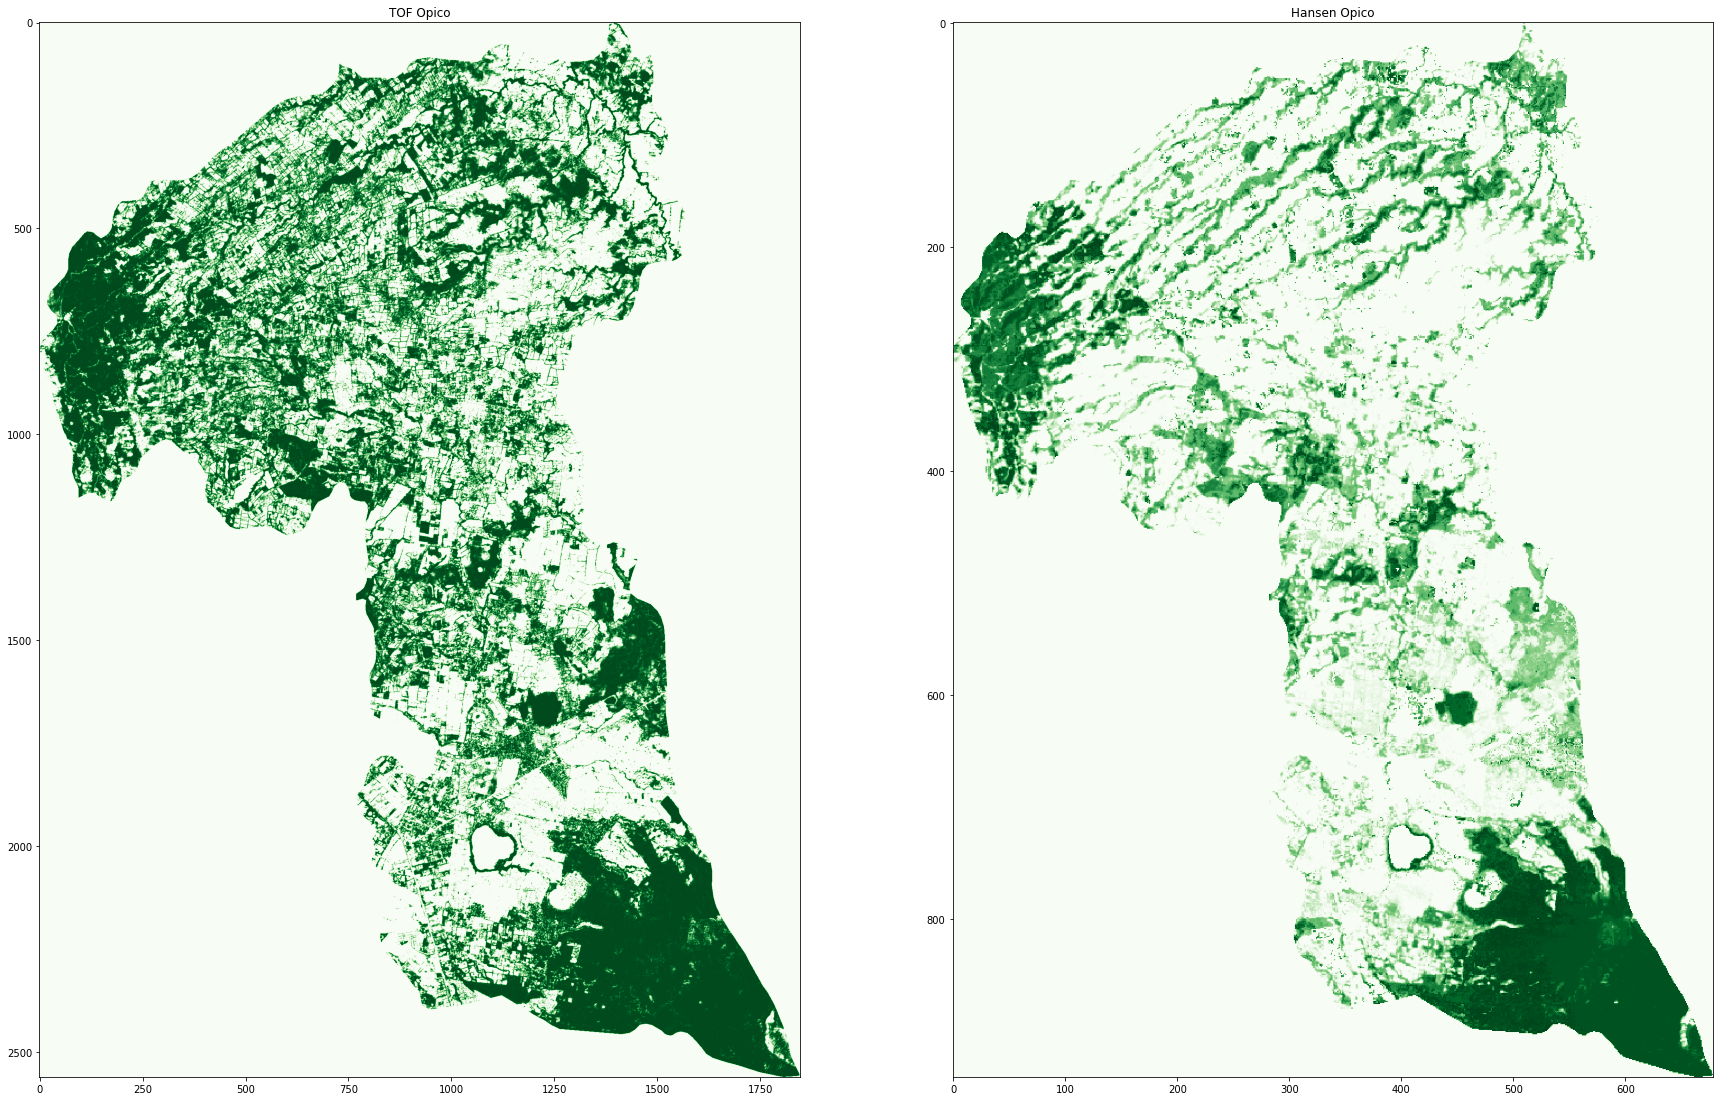

In [39]:
opico_tof = rs.open('El Salvador/clipped_rasters/tof/Opico.tif').read(1)
opico_han = rs.open('El Salvador/clipped_rasters/hansen/Opico.tif').read(1)
opico_tof.shape, opico_han.shape

plt.figure(figsize=(30,20))

plt.subplot(1,2,1)
plt.imshow(opico_tof, cmap='Greens', vmin=0, vmax=100)
plt.title('TOF Opico')

plt.subplot(1,2,2)
plt.imshow(opico_han, cmap='Greens', vmin=0, vmax=100)
plt.title('Hansen Opico')


plt.tight_layout;

In [38]:
panchimalco_tof = rs.open('El Salvador/clipped_rasters/tof/Panchimalco.tif').read(1)
panchimalco_han = rs.open('El Salvador/clipped_rasters/hansen/Panchimalco.tif').read(1)
panchimalco_tof.shape, panchimalco_han.shape


((1843, 1041), (678, 383))

## TOF vs Hansen

### Total Hectares per Jurisdiction

In [15]:
def v_groupedbar(bar1, bar2, figsize, barwidth, labels, title):
    
    xlabels = labels
    x = np.arange(len(labels))  
    width = barwidth  

    plt.figure(figsize=figsize)
    plt.bar(x - width/2, bar1, width, label='TOF', color='dodgerblue', edgecolor='white')
    plt.bar(x + width/2, bar2, width, label='Hansen', color='darkred', edgecolor='white')

    plt.title(title)
    plt.ylabel('Hectares')
    plt.xlabel('Jurisdiction')
    plt.xticks(x, labels=labels, rotation=80)
    plt.grid(axis='y', linestyle='-', linewidth=.2)
    plt.legend()
    plt.tight_layout()
    
    return None

In [16]:
def h_groupedbar(bar1, bar2, figsize, barwidth, labels, title, xlabel):
    
    ylabels = labels
    y = np.arange(len(bar1))
    width = barwidth

    plt.figure(figsize=figsize)
    plt.barh(x - width/2, bar1, width, label='TOF', color='dodgerblue', edgecolor='white')
    plt.barh(x + width/2, bar2, width, label='Hansen', color='darkred', edgecolor='white')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.yticks(y + width / 2, labels=labels)
    plt.grid(axis='x', linestyle='-', linewidth=.2)
    plt.legend()
    plt.tight_layout()
    
    return None

In [17]:
v_groupedbar(tvh.tof_total_ha[:30], tvh.hansen_total_ha[:30], 
             (12,7), 0.35, 
             list(tvh.jurisdiction)[:30], 
             'Total Hectares of Mean Tree Cover >10% in El Salvador (#1)')

AttributeError: 'DataFrame' object has no attribute 'tof_total_ha'

In [18]:
v_groupedbar(tvh.tof_total_ha[30:], tvh.hansen_total_ha[30:], 
             (12,7), 0.35, 
             list(tvh.jurisdiction)[30:], 
             'Total Hectares of Mean Tree Cover >10% in El Salvador (#2)')

AttributeError: 'DataFrame' object has no attribute 'tof_total_ha'

In [193]:
# where does TOF see the biggest difference?
tvh.sort_values(by='tof_hans', ascending=False)[:5]

jurisdiction  tof_mean_tc tof_total_ha  hansen_mean_tc hansen_total_ha  \
3       Jujutla       26.606        16974          14.555           12873   
16        Opico       23.850        18996          13.947           15663   
56    Sonsonate       16.146        16138           8.850           13286   
2     Guaymango       27.645         9031          12.511            6376   
42     Acajutla       14.289        12509           8.300            9899   

   tof_hans  
3      4101  
16     3333  
56     2852  
2      2655  
42     2610

In [199]:
jujutla_tof = rs.open('El Salvador/resampled_rasters/tof/Jujutla.tif').read(1)
jujutla_han = rs.open('El Salvador/resampled_rasters/hansen/Jujutla.tif').read(1)

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(jujutla_tof, cmap='Greens', vmin=0, vmax=100)
plt.title('TOF Tree Cover in Jujutla')

plt.subplot(1,2,2)
plt.imshow(jujutla_han, cmap='Greens', vmin=0, vmax=100)
plt.title('Hansen Tree Cover in Jujutla')


plt.tight_layout;

In [194]:
# where does Hansen see the biggest difference?
tvh.sort_values(by='tof_hans', ascending=True)[:5]

jurisdiction  tof_mean_tc tof_total_ha  hansen_mean_tc  \
46               Izalco       29.280        15315          24.869   
47               Juayúa       51.107         9832          47.523   
1   Concepción de Ataco       61.418         6281          58.504   
24             Tepecoyo       53.441         5813          49.233   
14   Nueva San Salvador       28.830        10850          23.222   

   hansen_total_ha tof_hans  
46           17575    -2260  
47           11779    -1947  
1             7555    -1274  
24            6774     -961  
14           11699     -849

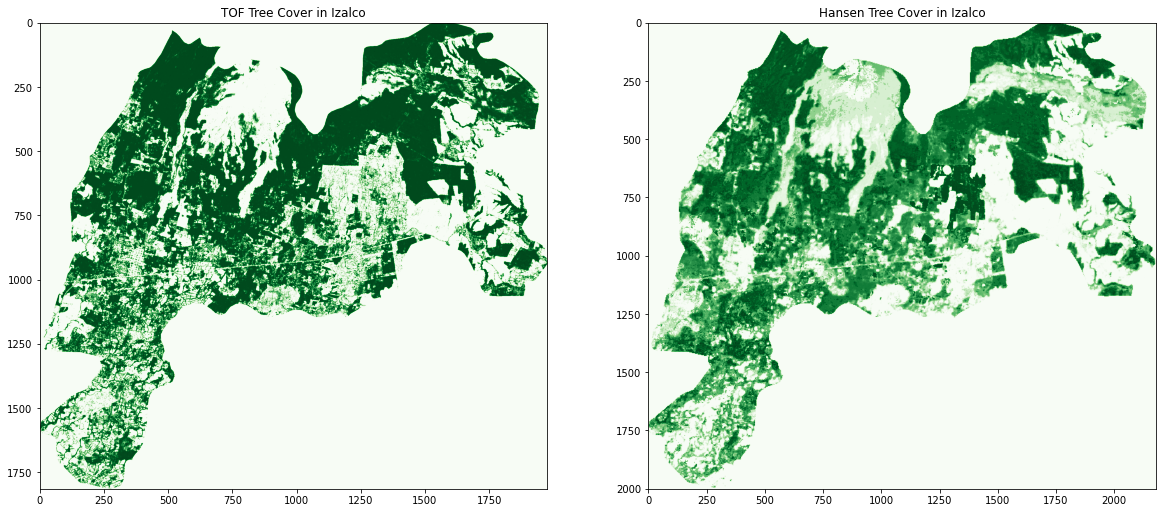

In [200]:
izalco_tof = rs.open('El Salvador/resampled_rasters/tof/Izalco.tif').read(1)
izalco_han = rs.open('El Salvador/resampled_rasters/hansen/Izalco.tif').read(1)

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(izalco_tof, cmap='Greens', vmin=0, vmax=100)
plt.title('TOF Tree Cover in Izalco')

plt.subplot(1,2,2)
plt.imshow(izalco_han, cmap='Greens', vmin=0, vmax=100)
plt.title('Hansen Tree Cover in Izalco')


plt.tight_layout;

## ESA Land Cover Classes

In [137]:
# define color palette
colors = ['royalblue','maroon', 'gray', 'sandybrown', 
          'gold', 'limegreen', 'green', 'palevioletred',
          'mediumturquoise', 'red', 'cyan', 'sienna', 'navy', 
          'mediumpurple', 'darkkhaki', 'magenta']

### Most Popular ESA Classes
What are the most popular land cover classes?

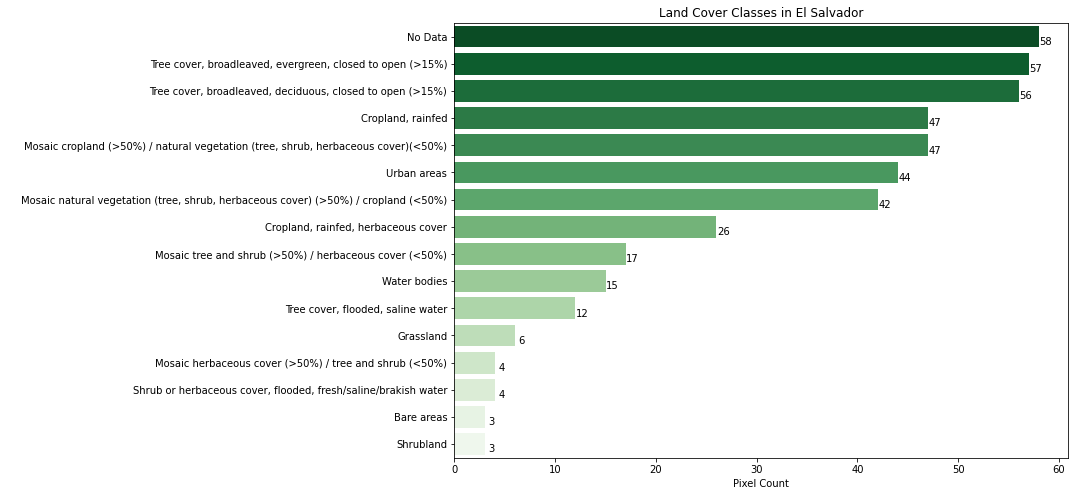

In [49]:
fig, ax = plt.subplots(figsize=(11,8))
sns.countplot(y='lc_class',
              data=landcover,
              palette='Greens_r',
              order=landcover.lc_class.value_counts().index,
              ax=ax)

for p, label in zip(ax.patches, landcover['lc_class'].value_counts(ascending=False)):
    x = p.get_x() + p.get_width() + 0.7
    y = p.get_y() + p.get_height()/2
    ax.annotate(label, (x,y), ha='center', va='top')

ax.set_title('Land Cover Classes in El Salvador')
ax.set_xlabel('Pixel Count')
ax.set_ylabel(' ');

### TOF vs Hansen Tree Cover per Land Cover Class

Compare TOF and Hansen tree cover estimates for each ESA and IPCC land cover class. Which land cover classes have the highest mean tree cover according to TOF and Hansen? Which have the highest number of hectares? 

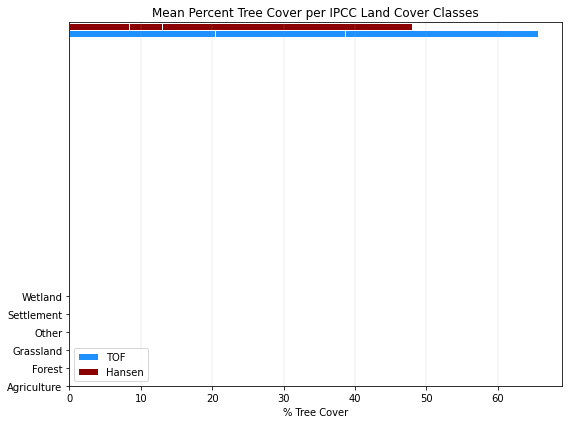

In [74]:
mean_per_ipcc = landcover[['tof_mean_tc', 
                           'hansen_mean_tc', 
                           'ipcc_class']].groupby('ipcc_class').mean().reset_index()

h_groupedbar(mean_per_ipcc['tof_mean_tc'], 
             mean_per_ipcc['hansen_mean_tc'], 
             figsize=(8,6), 
             barwidth=0.4, 
             labels=mean_per_ipcc['ipcc_class'].values, 
             title='Mean Percent Tree Cover per IPCC Land Cover Classes', 
             xlabel='% Tree Cover')

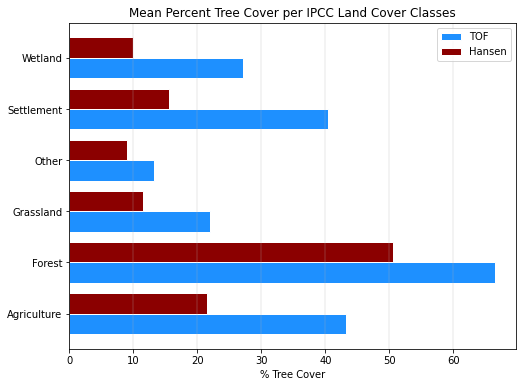

In [126]:
mean_per_ipcc = landcover[['tof_mean_tc', 
                           'hansen_mean_tc', 
                           'ipcc_class']].groupby('ipcc_class').mean().reset_index()
plt.figure(figsize=(8,6))

width = 0.4
pos1 = np.arange(len(mean_per_ipcc))
pos2 = pos1 + width

plt.barh(pos1, mean_per_ipcc['tof_mean_tc'], width, color='dodgerblue', edgecolor='white', label='TOF')
plt.barh(pos2, mean_per_ipcc['hansen_mean_tc'], width, color='darkred', edgecolor='white', label='Hansen')
 
plt.xlabel('% Tree Cover')
plt.yticks(pos1 + width / 2, mean_per_ipcc['ipcc_class'].values)

plt.legend()
plt.title('Mean Percent Tree Cover per IPCC Land Cover Classes')
plt.grid(axis='x', linestyle='-', linewidth=.3);


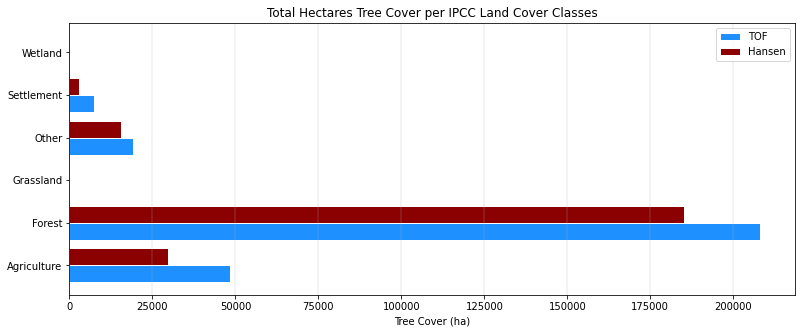

In [132]:
ha_per_ipcc = landcover[['tof_total_ha', 
                        'hansen_total_ha', 
                        'ipcc_class']].groupby('ipcc_class').sum().reset_index()

plt.figure(figsize=(13,5))

width = 0.4
pos1 = np.arange(len(ha_per_ipcc))
pos2 = pos1 + width

plt.barh(pos1, ha_per_ipcc['tof_total_ha'], width, color='dodgerblue', edgecolor='white', label='TOF')
plt.barh(pos2, ha_per_ipcc['hansen_total_ha'], width, color='darkred', edgecolor='white', label='Hansen')
 
plt.xlabel('Tree Cover (ha)')
plt.yticks(pos1 + width / 2, ha_per_ipcc['ipcc_class'].values)

plt.legend()
plt.title('Total Hectares Tree Cover per IPCC Land Cover Classes')
plt.grid(axis='x', linestyle='-', linewidth=.3);


In [121]:
ha_per_lc = landcover[['tof_total_ha', 
                       'hansen_total_ha', 
                       'lc_class']].groupby('lc_class').sum().sort_values('tof_total_ha').reset_index()

mean_per_lc = landcover[['tof_mean_tc', 
                       'hansen_mean_tc', 
                       'lc_class']].groupby('lc_class').mean().sort_values('tof_mean_tc').reset_index()

In [122]:
plt.figure(figsize=(10,8))

width = 0.4
pos1 = np.arange(len(mean_per_lc))
pos2 = pos1 + width

plt.barh(pos1, mean_per_lc['tof_mean_tc'], width, color='dodgerblue', edgecolor='white', label='TOF')
plt.barh(pos2, mean_per_lc['hansen_mean_tc'], width, color='darkred', edgecolor='white', label='Hansen')
 
plt.xlabel('% Tree Cover')
plt.yticks(pos1 + width / 2, mean_per_lc['lc_class'].values)

plt.legend()
plt.title('Mean Percent Tree Cover per Land Cover Class')
plt.grid(axis='x', linestyle='-', linewidth=.3);

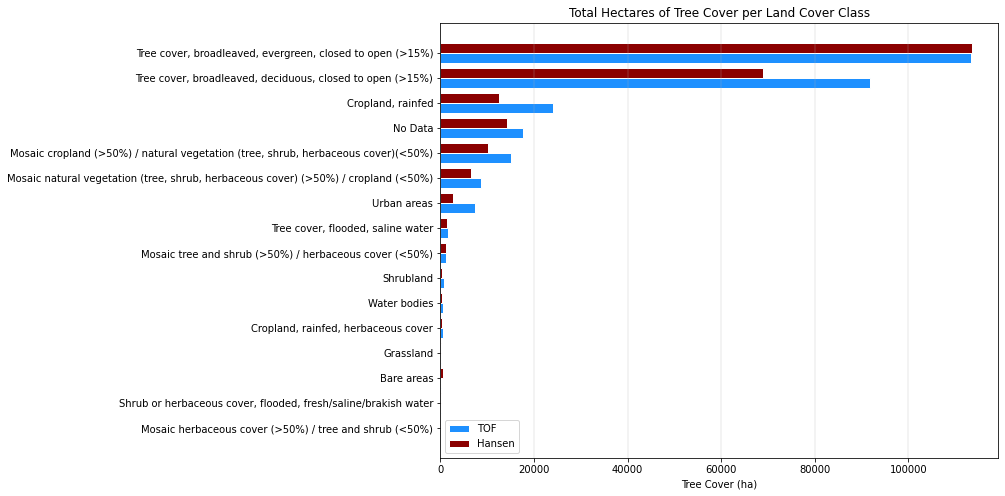

In [123]:
plt.figure(figsize=(10,8))

width = 0.4
 
# Set position of bar on X axis
pos1 = np.arange(len(ha_per_lc))
pos2 = pos1 + width

plt.barh(pos1, ha_per_lc['tof_total_ha'], width, color='dodgerblue', edgecolor='white', label='TOF')
plt.barh(pos2, ha_per_lc['hansen_total_ha'], width, color='darkred', edgecolor='white', label='Hansen')
 
# Add xticks on the middle of the group bars
plt.xlabel('Tree Cover (ha)')
plt.yticks(pos1 + width / 2, ha_per_lc['lc_class'].values)
 
# Create legend & Show graphic
plt.legend()
plt.title('Total Hectares of Tree Cover per Land Cover Class')
plt.grid(axis='x', linestyle='-', linewidth=.3);

### Conclusions
There are some land cover classes where we see large differences in mean percent tree cover between Hansen and TOF, but total hectares is exactly the same. This is because of the post processing technique used by Hansen to cap canopy cover based on the ecoregion or forest type.

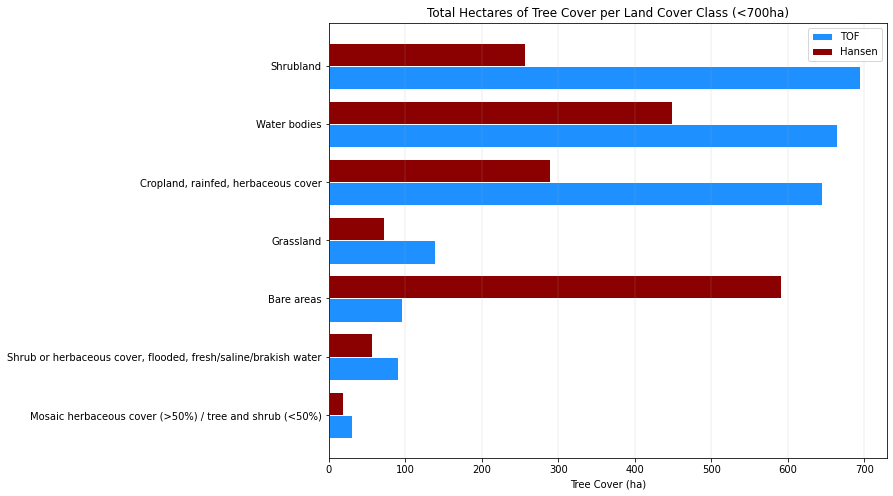

In [124]:
# zoom in on land categories with smaller count

plt.figure(figsize=(10,8))

width = 0.4
 
# Set position of bar on X axis
pos1 = np.arange(0,7)
pos2 = pos1 + width

plt.barh(pos1, ha_per_lc['tof_total_ha'][:7], width, color='dodgerblue', edgecolor='white', label='TOF')
plt.barh(pos2, ha_per_lc['hansen_total_ha'][:7], width, color='darkred', edgecolor='white', label='Hansen')
 
# Add xticks on the middle of the group bars
plt.xlabel('Tree Cover (ha)')
plt.yticks(pos1 + width / 2, ha_per_lc['lc_class'].values[:7])
 
# Create legend & Show graphic
plt.legend()
plt.title('Total Hectares of Tree Cover per Land Cover Class (<700ha)')
plt.grid(axis='x', linestyle='-', linewidth=.2);

### Tree Cover in No Data Class
What does tree cover look like in ESA's "No Data" class?

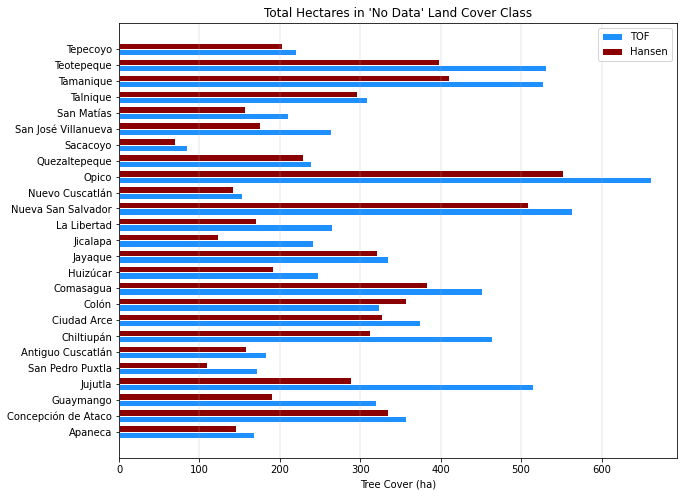

In [181]:
no_data25 = landcover[landcover.lc_class == 'No Data'][:25]

plt.figure(figsize=(10,8))
width = 0.4
 
# Set position of bar on X axis
pos1 = np.arange(len(no_data25))
pos2 = pos1 + width

plt.barh(pos1, no_data25['tof_total_ha'], width, color='dodgerblue', edgecolor='white', label='TOF')
plt.barh(pos2, no_data25['hansen_total_ha'], width, color='darkred', edgecolor='white', label='Hansen')
 
# Add xticks on the middle of the group bars
plt.xlabel('Tree Cover (ha)')
plt.yticks(pos1 + width / 2, no_data25['jurisdiction'].values)
 
# Create legend & Show graphic
plt.legend()
plt.title("Total Hectares in 'No Data' Land Cover Class")
plt.grid(axis='x', linestyle='-', linewidth=.3);

In [187]:
no_data33 = landcover[landcover.lc_class == 'No Data'][25:]

plt.figure(figsize=(10,8))
width = 0.4
 
# Set position of bar on X axis
pos1 = np.arange(len(no_data33))
pos2 = pos1 + width

plt.barh(pos1, no_data33['tof_total_ha'], width, color='dodgerblue', edgecolor='white', label='TOF')
plt.barh(pos2, no_data33['hansen_total_ha'], width, color='darkred', edgecolor='white', label='Hansen')
 
# Add xticks on the middle of the group bars
plt.xlabel('Tree Cover (ha)')
plt.yticks(pos1 + width / 2, no_data33['jurisdiction'].values)
 
# Create legend & Show graphic
plt.legend()
plt.title("Total Hectares in 'No Data' Land Cover Class")
plt.grid(axis='x', linestyle='-', linewidth=.3);

### Average and Total Difference per Class
What is the average and total difference between TOF and Hansen tree cover estimates?

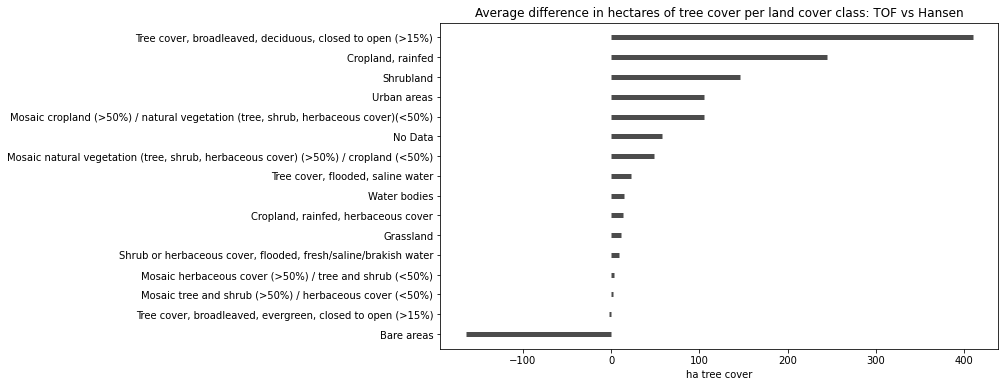

In [18]:
# Plots the average difference between total hecatares of tof and hansen for each land cover class
# the tof_hans column is calculated by tof total ha - hansen total ha

diverge_mean = landcover.groupby('lc_class')['tof_hans'].mean().sort_values().reset_index()
diverge_sum = landcover.groupby('lc_class')['tof_hans'].sum().sort_values().reset_index()
colors = ['red' if x < 0 else 'green' for x in diverge_mean.tof_hans]

plt.figure(figsize=(10,6))

plt.hlines(y=diverge_mean.lc_class, 
           xmin=0, 
           xmax=diverge_mean.tof_hans, 
           alpha=0.7,
           linewidth=5)

plt.title('Average difference in hectares of tree cover per land cover class: TOF vs Hansen')
plt.xlabel('ha tree cover');

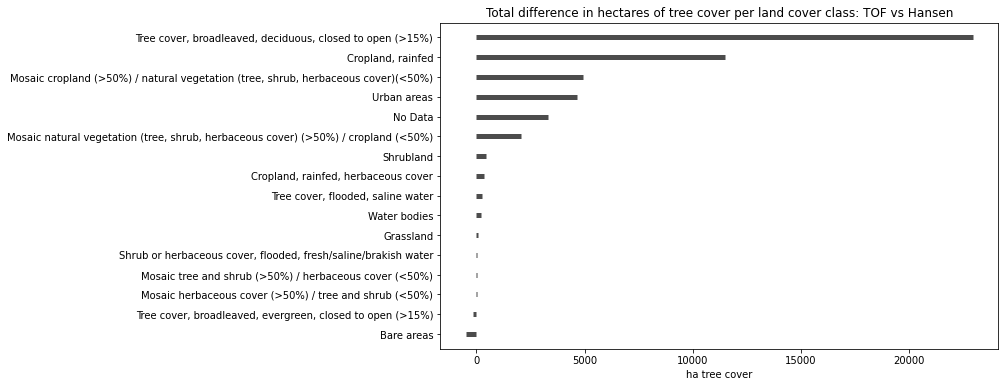

In [19]:
plt.figure(figsize=(10,6))

plt.hlines(y=diverge_sum.lc_class, 
           xmin=0, 
           xmax=diverge_sum.tof_hans, 
           alpha=0.7,
           linewidth=5)

plt.title('Total difference in hectares of tree cover per land cover class: TOF vs Hansen')
plt.xlabel('ha tree cover');

### Total Hectares per Class: Hansen v TOF
What does the distribution look like across all land cover classes?

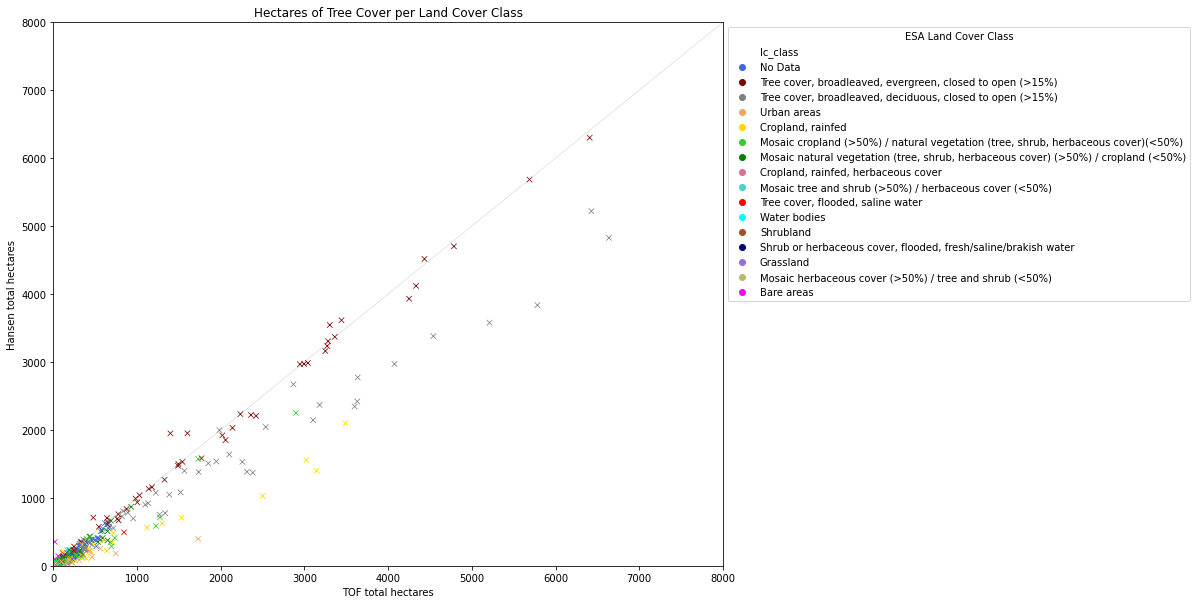

In [138]:
# All land cover classes 
fig, ax = plt.subplots(figsize=(12,10))

sns.scatterplot(x='tof_total_ha', 
               y='hansen_total_ha', 
               data=landcover, 
               hue='lc_class',
               marker='x',
               s=30,
               palette=colors,
               ax=ax)
ax.set(xlim=(0, 8000), ylim=(0, 8000))
ax.plot(np.arange(0.001, 8000, 1), color='grey', linewidth=.2)
ax.set_title('Hectares of Tree Cover per Land Cover Class')
ax.set_xlabel('TOF total hectares')
ax.set_ylabel('Hansen total hectares')


plt.legend(bbox_to_anchor=(1.0, 1), title='ESA Land Cover Class');

In [140]:
under500 = landcover[(landcover.tof_total_ha <= 500) & (landcover.hansen_total_ha <= 500)]
under2k = landcover[(landcover.tof_total_ha <= 2000) & (landcover.hansen_total_ha <= 2000)]

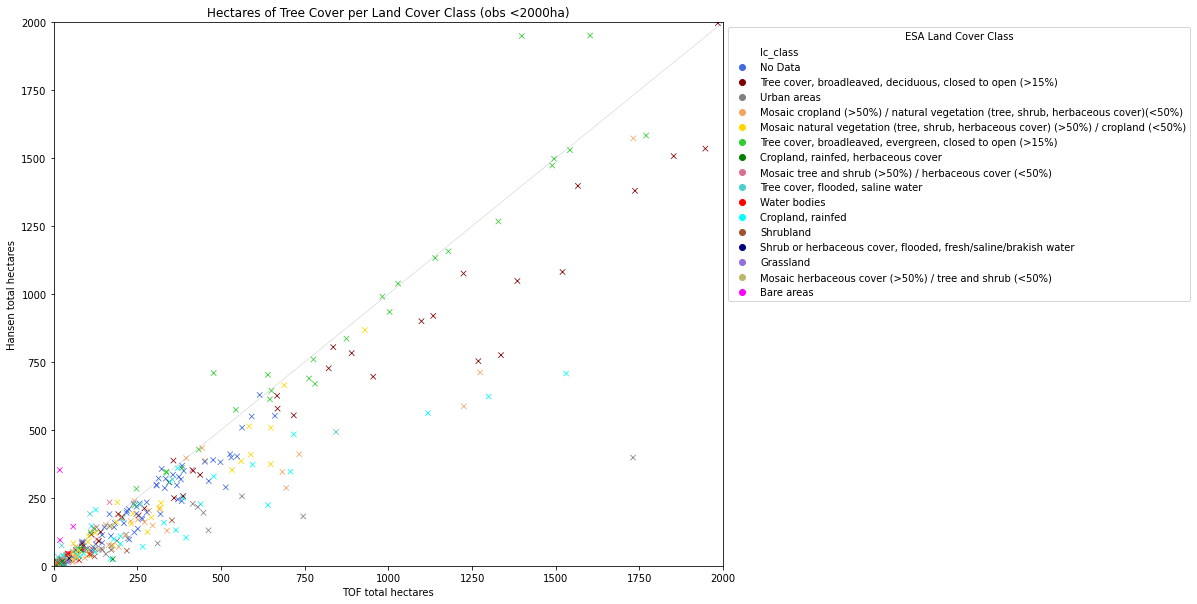

In [141]:
# All land cover classes for obs <2000ha
fig, ax = plt.subplots(figsize=(12,10))

sns.scatterplot(x='tof_total_ha', 
               y='hansen_total_ha', 
               data=under2k, 
               hue='lc_class',
               marker='x',
               s=30,
               palette=colors,
               ax=ax)
ax.set(xlim=(0, 2000), ylim=(0, 2000))
ax.plot(np.arange(0.001, 3000, 1), color='grey', linewidth=.2)
ax.set_title('Hectares of Tree Cover per Land Cover Class (obs <2000ha)')
ax.set_xlabel('TOF total hectares')
ax.set_ylabel('Hansen total hectares')


plt.legend(bbox_to_anchor=(1.0, 1), title='ESA Land Cover Class');

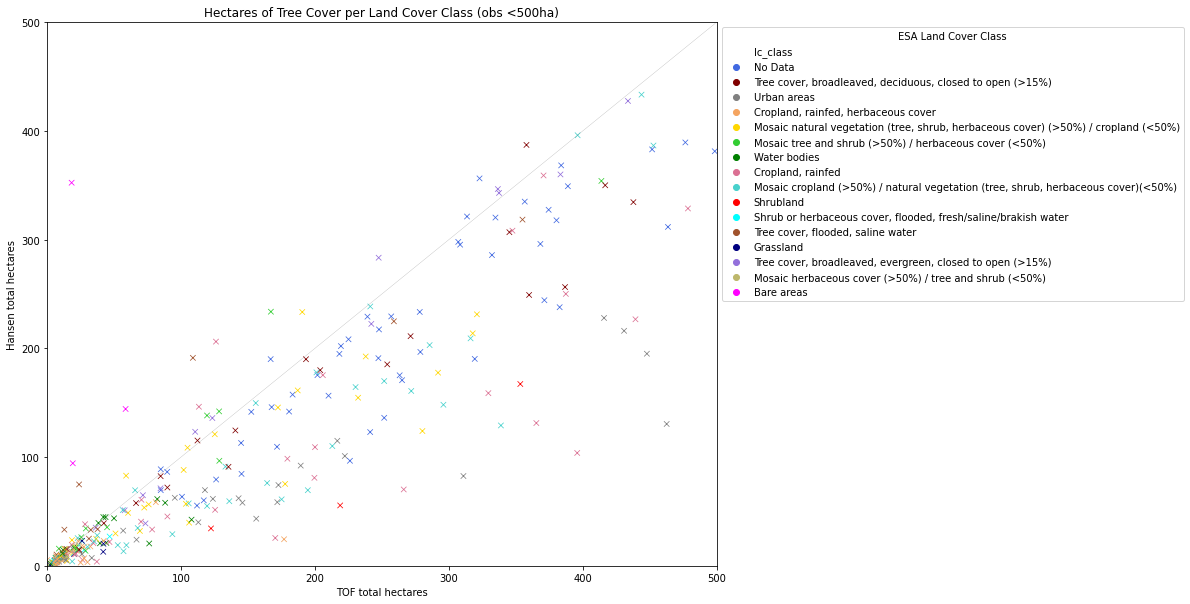

In [142]:
# All land cover classes for obs <500ha
fig, ax = plt.subplots(figsize=(12,10))

sns.scatterplot(x='tof_total_ha', 
               y='hansen_total_ha', 
               data=under500, 
               hue='lc_class',
               marker='x',
               s=30,
               palette=colors,
               ax=ax)
ax.set(xlim=(0, 500), ylim=(0, 500))
ax.plot(np.arange(0.001, 500, 1), color='grey', linewidth=.2)
ax.set_title('Hectares of Tree Cover per Land Cover Class (obs <500ha)')
ax.set_xlabel('TOF total hectares')
ax.set_ylabel('Hansen total hectares')

plt.legend(bbox_to_anchor=(1.0, 1), title='ESA Land Cover Class');

In [143]:
forest = landcover[landcover.ipcc_class == 'Forest']
agriculture = landcover[landcover.ipcc_class == 'Agriculture']
settlement = landcover[landcover.ipcc_class == 'Settlement']
grassland = landcover[landcover.ipcc_class == 'Grassland']
wetland = landcover[landcover.ipcc_class == 'Wetland']
other = landcover[landcover.ipcc_class == 'Other']

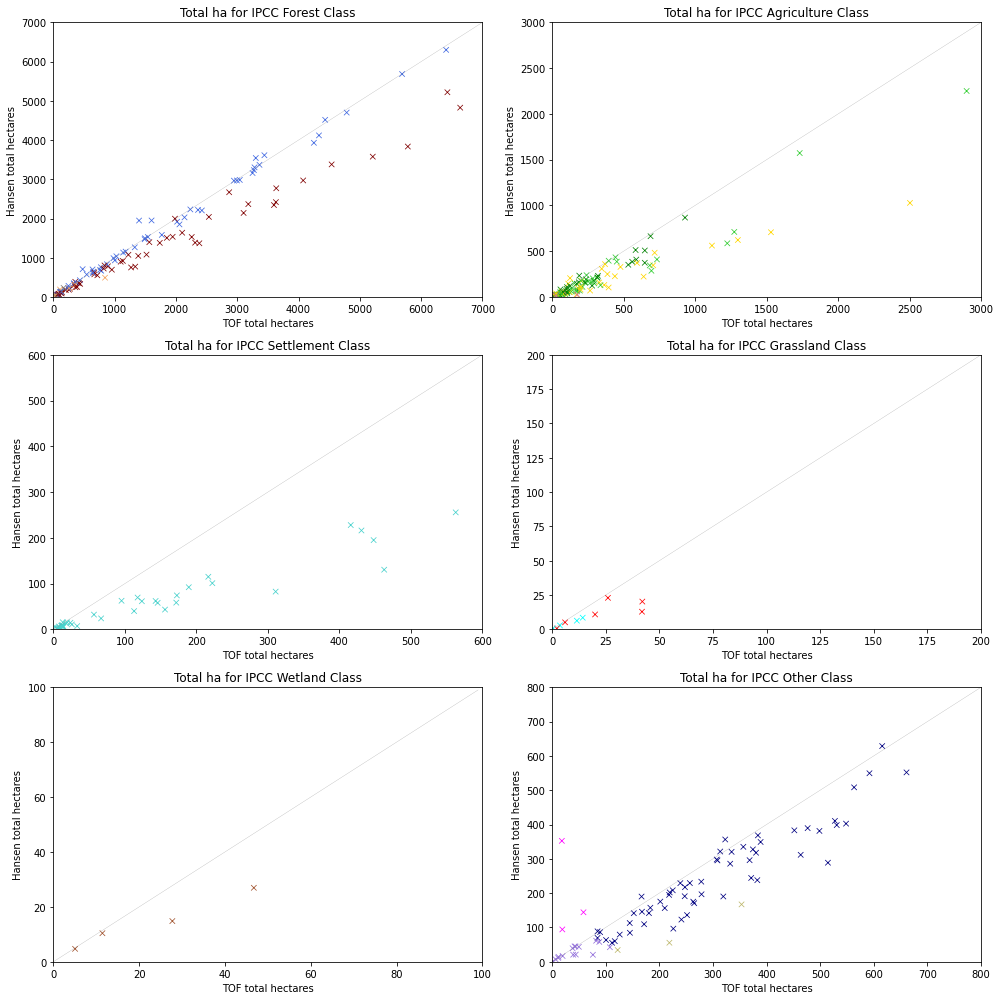

In [169]:
# update these groupings to be for ipcc classes?
plt.figure(figsize=(14,14))

ax1 = plt.subplot(3,2,1)
sns.scatterplot(x='tof_total_ha', 
               y='hansen_total_ha', 
               data=forest, 
               hue='lc_class',
               marker='x',
               s=30,
               palette=colors[:4],
               ax=ax1,
               legend=False)
ax1.set(xlim=(0, 7000), ylim=(0, 7000))
ax1.plot(np.arange(0.001, 8000, 1), color='grey', linewidth=.2)
ax1.set_title('Total ha for IPCC Forest Class')
ax1.set_xlabel('TOF total hectares')
ax1.set_ylabel('Hansen total hectares')

ax2 = plt.subplot(3,2,2)
sns.scatterplot(x='tof_total_ha', 
               y='hansen_total_ha', 
               data=agriculture, 
               hue='lc_class',
               marker='x',
               s=30,
               palette=colors[4:8],
               ax=ax2,
               legend=False)
ax2.set(xlim=(0, 3000), ylim=(0, 3000))
ax2.plot(np.arange(0.001, 3000, 1), color='grey', linewidth=.2)
ax2.set_title('Total ha for IPCC Agriculture Class')
ax2.set_xlabel('TOF total hectares')
ax2.set_ylabel('Hansen total hectares')


ax3 = plt.subplot(3,2,3)
sns.scatterplot(x='tof_total_ha', 
               y='hansen_total_ha', 
               data=settlement, 
               hue='lc_class',
               marker='x',
               s=30,
               palette=colors[8:9],
               ax=ax3,
               legend=False)
ax3.set(xlim=(0, 600), ylim=(0, 600))
ax3.plot(np.arange(0.001, 700, 1), color='grey', linewidth=.2)
ax3.set_title('Total ha for IPCC Settlement Class')
ax3.set_xlabel('TOF total hectares')
ax3.set_ylabel('Hansen total hectares')

ax4 = plt.subplot(3,2,4)
sns.scatterplot(x='tof_total_ha', 
               y='hansen_total_ha', 
               data=grassland, 
               hue='lc_class',
               marker='x',
               s=30,
               palette=colors[9:11],
               ax=ax4,
               legend=False)
ax4.set(xlim=(0, 200), ylim=(0, 200))
ax4.plot(np.arange(0.001, 1000, 1), color='grey', linewidth=.2)
ax4.set_title('Total ha for IPCC Grassland Class')
ax4.set_xlabel('TOF total hectares')
ax4.set_ylabel('Hansen total hectares')

ax5 = plt.subplot(3,2,5)
sns.scatterplot(x='tof_total_ha', 
               y='hansen_total_ha', 
               data=wetland, 
               hue='lc_class',
               marker='x',
               s=30,
               palette=colors[11:12],
               ax=ax5,
               legend=False)
ax5.set(xlim=(0, 100), ylim=(0, 100))
ax5.plot(np.arange(0.001, 100, 1), color='grey', linewidth=.2)
ax5.set_title('Total ha for IPCC Wetland Class')
ax5.set_xlabel('TOF total hectares')
ax5.set_ylabel('Hansen total hectares')

ax6 = plt.subplot(3,2,6)
sns.scatterplot(x='tof_total_ha', 
               y='hansen_total_ha', 
               data=other, 
               hue='lc_class',
               marker='x',
               s=30,
               palette=colors[12:],
               ax=ax6,
               legend=False)
ax6.set(xlim=(0, 800), ylim=(0, 800))
ax6.plot(np.arange(0.001, 800, 1), color='grey', linewidth=.2)
ax6.set_title('Total ha for IPCC Other Class')
ax6.set_xlabel('TOF total hectares')
ax6.set_ylabel('Hansen total hectares')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.tight_layout();


### Clipped & Resampled Jurisdictional Rasters

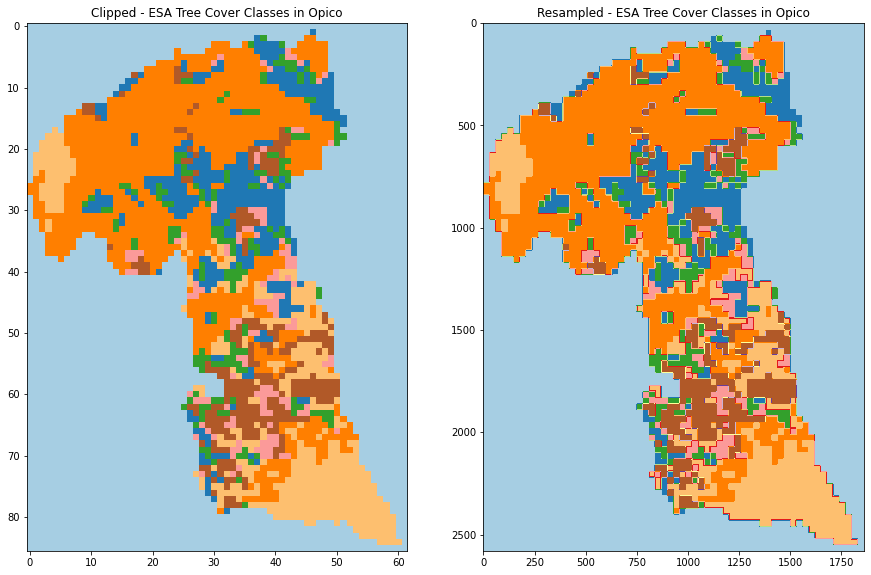

In [52]:
plt.figure(figsize=(15,10))

opico_esa_resampled = rs.open('resampled_rasters/esa/Opico.tif').read(1)
opico_esa_clipped = rs.open('clipped_rasters/esa/Opico.tif').read(1)

plt.subplot(1,2,1)
plt.imshow(opico_esa_clipped, cmap='Paired', vmin=0, vmax=100)
plt.title('Clipped - ESA Tree Cover Classes in Opico')

plt.subplot(1,2,2)
plt.imshow(opico_esa_resampled, cmap='Paired', vmin=0, vmax=100)
plt.title('Resampled - ESA Tree Cover Classes in Opico')

plt.tight_layout;

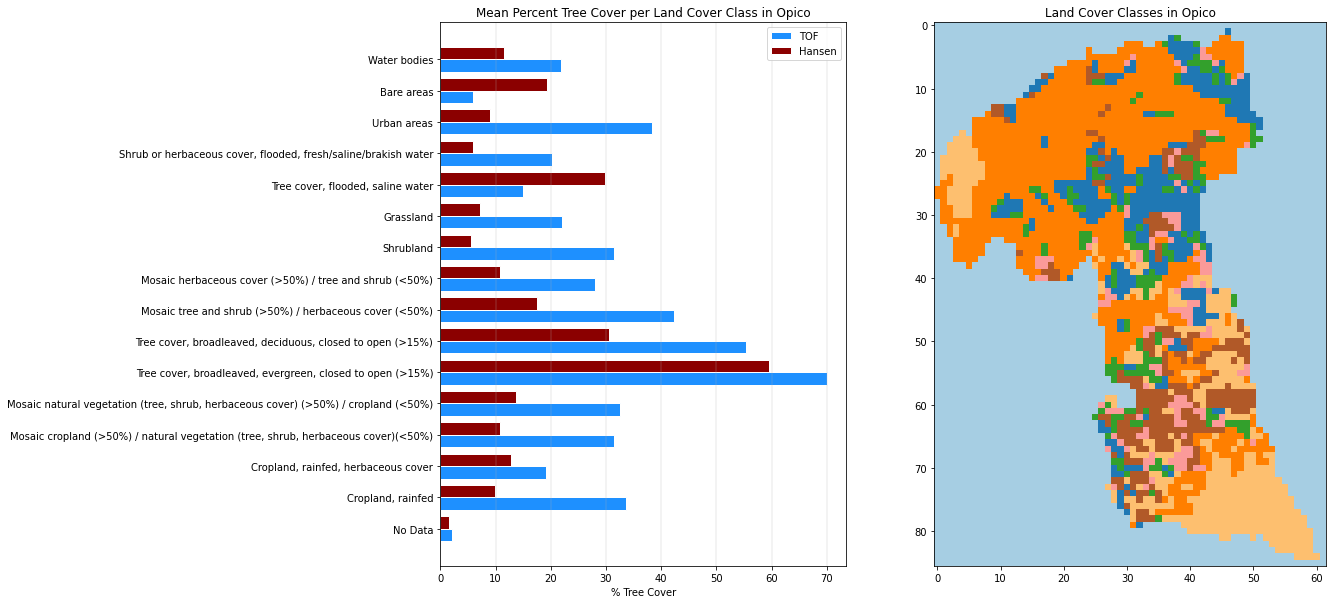

In [229]:
plt.figure(figsize=(16,10))
opico_esa = rs.open('El Salvador/clipped_rasters/esa/Opico.tif').read(1)
opico = landcover[landcover.jurisdiction == 'Opico']

ax1 = plt.subplot(1,2,1)

width = 0.4
pos1 = np.arange(len(opico))
pos2 = pos1 + width

ax1.barh(pos1, opico['tof_mean_tc'], width, color='dodgerblue', edgecolor='white', label='TOF')
ax1.barh(pos2, opico['hansen_mean_tc'], width, color='darkred', edgecolor='white', label='Hansen')
 
plt.xlabel('% Tree Cover')
plt.yticks(pos1 + width / 2, opico['lc_class'].values)

plt.legend()
ax1.set_title('Mean Percent Tree Cover per Land Cover Class in Opico')
plt.grid(axis='x', linestyle='-', linewidth=.3)

ax2 = plt.subplot(1,2,2)
ax2.imshow(opico_esa, cmap='Paired', vmin=0, vmax=100)
ax2.set_title('Land Cover Classes in Opico');


## Old Code

In [19]:
jurisdictions = gpd.read_file('El Salvador/El Salvador_admin.geojson')

In [4]:
cr_admins = gpd.read_file('Costa Rica/cri_admbnda_adm2_2020.shp')
cr_admins.head()

ADM0_PCODE     ADM0_ES ADM1_PCODE     ADM1_ES    ADM2_REF ADM2_PCODE  \
0         CR  Costa Rica       CR03  Guanacaste  Guanacaste     CR0301   
1         CR  Costa Rica       CR07    San José    San José     CR0701   
2         CR  Costa Rica       CR06  Puntarenas  Puntarenas     CR0601   
3         CR  Costa Rica       CR01    Alajuela    Alajuela     CR0101   
4         CR  Costa Rica       CR07    San José    San José     CR0702   

      ADM2_ES                                           geometry  
0   Abangares  MULTIPOLYGON (((375722.282 1121031.337, 375696...  
1      Acosta  POLYGON ((482255.682 1090408.565, 482281.722 1...  
2     Aguirre  MULTIPOLYGON (((486711.014 1033380.147, 486700...  
3    Alajuela  POLYGON ((482377.488 1151480.958, 482376.471 1...  
4  Alajuelita  POLYGON ((487024.603 1098008.676, 487070.576 1...

In [5]:
# reproject the shapefile if not espg 4326
cr_admins = cr_admins.to_crs('"EPSG:4326"')

In [30]:
cr_bounds = cr_admins.geometry.bounds
cr_bounds

minx       miny       maxx       maxy
0  -85.225659  10.109038 -84.827092  10.389386
1  -84.341693   9.622506 -84.132088   9.861633
2  -84.253801   9.254671 -83.840040   9.572033
3  -84.367680   9.914267 -84.160955  10.413694
4  -84.145894   9.847564 -84.084156   9.931675
..        ...        ...        ...        ...
76 -84.592696   9.569590 -84.403502   9.925489
77 -85.449169  10.670787 -84.880578  11.065570
78 -84.362149  10.048149 -84.226587  10.276312
79 -84.034999   9.964382 -83.858583  10.190042
80 -84.518360  10.167054 -84.315016  10.270422

[81 rows x 4 columns]

In [28]:
bounds = jurisdictions.geometry.bounds
min_x = bounds.minx.min()
min_y = bounds.miny.min()
max_x = bounds.maxx.max()
max_y = bounds.maxy.max()
min_x, min_y, max_x, max_y

(-90.03624725299994, 13.417916298000023, -88.95311737099996, 13.99701213800006)

In [43]:
lower_x = math.floor(min_x / 10) * 10
lower_y = math.ceil(min_y / 10) * 10
upper_y = math.ceil(max_y / 10) * 10
upper_x = math.ceil(max_x / 10) * 10

In [44]:
lower_x, lower_y, upper_x, upper_y

(-100, 20, -80, 20)

In [52]:
for x in range(lower_x, upper_x, 10):
    print(x)

-100
-90


In [53]:
for x in range(lower_y, upper_y + 10, 10):
    print(x)

20


In [21]:
# lower_x = np.absolute(math.floor(min_x / 10) * 10)
# lower_y = np.absolute(math.floor(min_y / 10) * 10)
# upper_y = np.absolute(math.ceil(max_y / 10) * 10)
# upper_x = np.absolute(math.ceil(max_x / 10) * 10)
# lower_x, lower_y, upper_x, upper_y